In [1]:
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import datetime
import pickle
import glob
import cv2
import os

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split as trainTestSplit

from skimage.feature import hog
from skimage import color, exposure


### Load The Data

In [197]:
dataFile = 'sample_data_file_names.p'

if not os.path.isfile(dataFile):
    path = "C:\\data\\detection\\class\\"
    cars_udacity = glob.glob(path + 'Udacity\\vehicles\*\*.jpeg')
    #print(len(cars_udacity))
    not_cars_udacity = glob.glob(path + 'Udacity\\non-vehicles\*\*.jpeg')
    #print(len(not_cars_udacity))
    cars_gti = glob.glob(path + 'GTI\\vehicles\*\*.png')
    #print(len(cars_gti))
    not_cars_gti = glob.glob(path + 'GTI\\non-vehicles\*\*.png')
    #print(len(not_cars_gti))
    cars_kitti = glob.glob(path + 'KITTI\\vehicles\*\*.png')
    #print(len(cars_kitti))
    not_cars_kitti = glob.glob(path + 'KITTI\\non-vehicles\*\*.png')
    #print(len(not_cars_kitti))
    
    image_samples = cars_udacity + cars_gti + cars_kitti + not_cars_udacity + not_cars_gti + not_cars_kitti
    y = np.concatenate((np.ones(len(cars_udacity)),np.ones(len(cars_gti)),np.ones(len(cars_kitti)),
                       np.zeros(len(not_cars_udacity)),np.zeros(len(not_cars_gti)),np.zeros(len(not_cars_kitti))))

    imageSamplesFiles, y = shuffle(image_samples, y)
    X_train, X_test, y_train, y_test = trainTestSplit(imageSamplesFiles, y, test_size=0.2, random_state=42)
    X_train, X_valid, y_train, y_valid = trainTestSplit(X_train, y_train, test_size=0.2, random_state=42)

    data = {'X_train': X_train, 'X_test': X_test, 'X_valid': X_valid, 'y_train': y_train, 'y_test': y_test, 'y_valid': y_valid}
    pickle.dump(data, open(dataFile, 'wb'))

with open(dataFile, mode='rb') as f:
    data = pickle.load(f)
    X_train = data['X_train']
    X_test = data['X_test']
    X_valid = data['X_valid']
    y_train = data['y_train']
    y_test = data['y_test']
    y_valid = data['y_valid']

train_samples = [(X_train[i], y_train[i]) for i in range(len(X_train))] 
test_samples = [(X_test[i], y_test[i]) for i in range(len(X_test))] 
validation_samples = [(X_valid[i], y_valid[i]) for i in range(len(X_valid))] 


### Dataset Summary & Exploration


Number of training examples = 13283
Number of validation examples = 3321
Number of testing examples = 4152



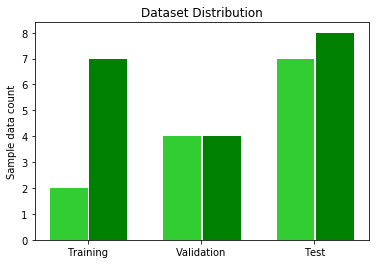

In [205]:

# Number of training examples
n_train = format(len(X_train))

# Number of validation examples
n_validation = format(len(X_valid))

# Number of testing examples
n_test = format(len(X_test))

# Shape of an traffic sign image
#image_shape = format(X_train[0].shape)

print()
print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print()
#print("Image data shape =", image_shape)

indices = range(0, 3)
width = np.min(np.diff(indices))/3
fig, ax = plt.subplots()
rects1 = ax.bar(np.arange(3), (2,4,7), width, color='limegreen')
rects2 = ax.bar(np.arange(3)+ 0.35, (7,4,8), width, color='green')
ax.set_ylabel('Sample data count')
ax.set_title('Dataset Distribution')
ax.set_xticks(np.arange(3) + width / 2)
ax.set_xticklabels(('Training', 'Validation', 'Test'))
plt.show()

In [17]:
img_input_shape=(720, 1280, 3)
height_of_interest = (400, 700)
image_interest = (height_of_interest[1] - height_of_interest[0], img_input_shape[1], img_input_shape[2])
print(image_interest)

(300, 1280, 3)


### Model Architecture

In [5]:
from keras.layers import Conv2D, Flatten, Lambda, MaxPooling2D, Dropout
from keras.callbacks import ModelCheckpoint
from keras.models import Model, Sequential

def generate_model(input_shape=(64, 64, 3)):
    dropout = 0.5
    model = Sequential()
    #normalization and mean zero - centered around zero with small standard deviation 
    model.add(Lambda(lambda x: x / 255., input_shape=input_shape, output_shape=input_shape))
    model.add(Conv2D(filters=16, kernel_size=(3, 3), padding="same", activation='relu', input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(Dropout(dropout))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(8, 8)))
    model.add(Dropout(dropout))
    model.add(Conv2D(filters=1, kernel_size=(8, 8), activation="sigmoid"))
    return model

Using TensorFlow backend.


In [6]:
import cv2
import numpy as np
import random
from sklearn.utils import shuffle

def generator(samples, batch_size=32, is_training=False):
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, len(samples), batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images, classification = [], []
            X_train, y_train = [], []
            
            for batch_sample in batch_samples:
                fileName = batch_sample[0]
                image = cv2.imread(fileName)
                
                # Adding the original images, flipping them and append to the dataset
                images.append(image)
                classification.append(batch_sample[1])
                
                if (is_training):
                    images.append(cv2.flip(image, 1))
                    classification.append(batch_sample[1])
                 
            X_train = np.array(images)
            y_train = np.expand_dims(classification, axis=1)
            yield shuffle(X_train, y_train)

# compile and train the model using the generator function
batch_size = 32
train_generator = generator(train_samples, batch_size, is_training=True)
validation_generator = generator(validation_samples, batch_size)
test_generator = generator(test_samples, batch_size)

In [51]:
from time import time
start_time = time()

epochs=2
batch_size = 32

model = generate_model()
model = Model(inputs=model.input, outputs=Flatten()(model.output))
print(model.summary())
        
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
checkpoint = ModelCheckpoint(filepath='model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history_object = model.fit_generator(train_generator, steps_per_epoch= len(train_samples)*2/batch_size, 
                validation_data=validation_generator, validation_steps=len(validation_samples)/batch_size,
                epochs=epochs, callbacks=[checkpoint])

total_time = time() - start_time
minutes, seconds = divmod(total_time, 60)
print ("Total time for training: ", minutes, "min, {:.0f}".format(seconds),  "s ")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_17_input (InputLayer) (None, 64, 64, 3)         0         
_________________________________________________________________
lambda_17 (Lambda)           (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 64, 64, 16)        448       
_________________________________________________________________
dropout_49 (Dropout)         (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
dropout_50 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 64, 64, 64)        18496     
__________

In [ ]:
accuracy = model.evaluate_generator(generator=test_generator, steps=len(test_samples)/ batch_size)

print('Test accuracy: ', accuracy)

### Loading the model weights before using it to predict the search windows

In [43]:
model = generate_model(input_shape = image_interest)
#cnnModel.load_weights('model.h5')
model.load_weights('ppico.h5')

vehicleBoxesHistory = []

(300, 1280, 3)


In [69]:
def search_windows(img):

    confidence_thresh = .5
    win_size = 64
    boxes = []
        
    # running on the region of interest only
    img_region = img[height_of_interest[0]:height_of_interest[1], :]
    img_region = np.expand_dims(img_region, axis=0)

    # 1. running model prediction on the region of interest
    # 2. convert the result to 2 dimentions (the model insist of 4 dimentions)
    # 3. using threshold of 0.5 on the results to get boolean classification results 
    model_detections = model.predict(img_region)
    model_detections = model_detections.reshape(model_detections.shape[1], model_detections.shape[2])
    model_detections = model_detections > confidence_thresh
    
    y_region = img_region.shape[1] / model_detections.shape[0]
    x_region = img_region.shape[2] / model_detections.shape[1]
    labels = label(model_detections, structure=[[1, 1, 1],[1, 1, 1],[1, 1, 1]])

    for box in range(labels[1]):

        nz = (labels[0] == box + 1).nonzero()
        nysteps = np.array(nz[0])
        nxsteps = np.array(nz[1])
        y_win_min = np.min(nysteps)
        x_win_min = np.min(nxsteps) - win_size/2
        x_win_max = np.max(nxsteps) + win_size/2
        y_win_max = np.max(nysteps) + win_size
        xspan = x_win_max - x_win_min
        yspan = y_win_max - y_win_min
        
        for x, y in zip(nxsteps, nysteps):

            offsetX = (x - x_win_min) / xspan * win_size
            offsetY = (y - y_win_min) / yspan * win_size
            top_left_X = int(round(x * x_region - offsetX, 0))
            top_left_Y = int(round(y * y_region - offsetY, 0))
            bottom_right_X = top_left_X + win_size
            bottom_right_Y = top_left_Y + win_size
            topLeft = (top_left_X, height_of_interest[0] + top_left_Y)
            bottomRight = (bottom_right_X, height_of_interest[0] + bottom_right_Y)

            boxes.append((topLeft, bottomRight))
            
    mask = np.zeros_like(img[:, :, 0]).astype(np.float)
    mask, heatMap = create_heatMap(mask, bBoxes=boxes)

    newBoxes = label(mask, structure=[[1, 1, 1],[1, 1, 1],[1, 1, 1]])
    save_boxes(newBoxes)

    return heatMap

In [159]:
def create_heatMap(mask, bBoxes):
    for box in bBoxes:
        mask[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        mask = np.clip(mask, 0, 255)
        
    heatMapInt = cv2.equalizeHist(mask.astype(np.uint8))
    heatMap = cv2.applyColorMap(heatMapInt, cv2.COLORMAP_HOT)
    heatMap = cv2.cvtColor(heatMap, code=cv2.COLOR_BGR2RGB)
    return mask, heatMap

# Adding the current boxes that were found, to the list of latest boxes
def save_boxes(newBoxes):
    global previous_boxes
    for i in range(newBoxes[1]):
        box = (newBoxes[0] == i + 1).nonzero()
        if (np.min(np.array(box[1])) > 300):
            previous_boxes.append([np.min(np.array(box[1])), np.min(np.array(box[0])), 
                                        np.max(np.array(box[1])), np.max(np.array(box[0]))])
            previous_boxes = previous_boxes[-45:] # will save the latest 45 boxes obly 

def group_regions():
    global previous_boxes
    #print(previous_boxes)
    #boxes, _ = cv2.groupRectangles(rectList=np.array(previous_boxes).tolist(), groupThreshold=0, eps=.0)
    boxes, _ = cv2.groupRectangles(rectList=np.array(previous_boxes).tolist(), groupThreshold=10, eps=.1)
    return boxes

def draw_boxes(img, bBoxes):
    for bBox in bBoxes:
        bBox = np.array(bBox)
        bBox = bBox.reshape(bBox.size)
        cv2.rectangle(img=img, pt1=(bBox[0], bBox[1]), pt2=(bBox[2], bBox[3]), color=(64,225,101), thickness=4)
        font=cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img,'Vehicle',(bBox[0]+10, bBox[1]-5), font, 0.6,(255,255,255),2)


### Main pipeline
The methos below gets an image and perform the following steps:
1. crop the image for the region of interest (the road part of the image)
2. running the model prediction on the image
3. arrange the detected boxes from the model output
4. run Heat-Map on the boxes array to detect the Hot pixels on the image
5. draw the boxes on the original image
The methos output is the original image with boxed around the cars detected on the image, including the HeatMap of the model output  

In [160]:
def detect_vehicles(img):

    # Search for matches by the model
    heatmap = search_windows(img)

    # group boxes togther to one 
    vBoxes = group_regions()
    
    draw_boxes(img, vBoxes)
    
    return img#, heatmap

In [163]:
# Test the pipeline for videos
from moviepy.editor import VideoFileClip
from IPython.display import HTML

previous_boxes=[]
white_output = ('C:\\data\\detection\\test_video_output.mp4')
clip1 = VideoFileClip("C:\\data\\detection\\test_video.mp4")
white_clip = clip1.fl_image(detect_vehicles)#.subclip(6,10)
%time white_clip.write_videofile(white_output, audio=False)
clip1.reader.close()
clip1.audio.reader.close_proc()

OSError: [WinError 6] The handle is invalid

[[794, 400, 1010, 518], [1048, 400, 1279, 527]]


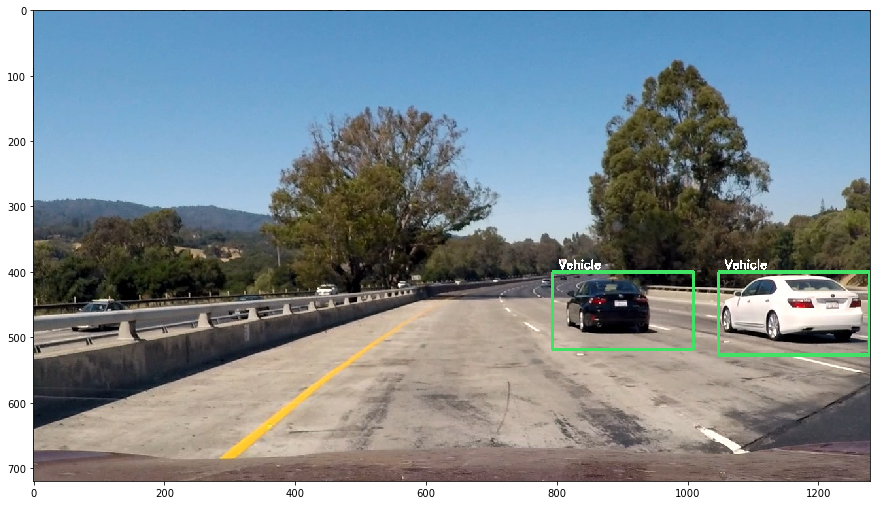

In [157]:
previous_boxes=[]
img = mpimg.imread('C:\\data\\detection\\templates\\test1.jpg')
output, heatmap = detect_vehicles(img)
plt.figure(figsize=(15, 12))
plt.imshow(output)

[[794, 400, 1010, 518], [1048, 400, 1279, 527]]
[]
[[866, 400, 974, 490]]
[[786, 400, 1010, 518], [1039, 400, 1279, 527]]
[[785, 400, 954, 499], [1088, 400, 1279, 545]]
[[785, 400, 954, 518], [1031, 400, 1269, 518]]
[]


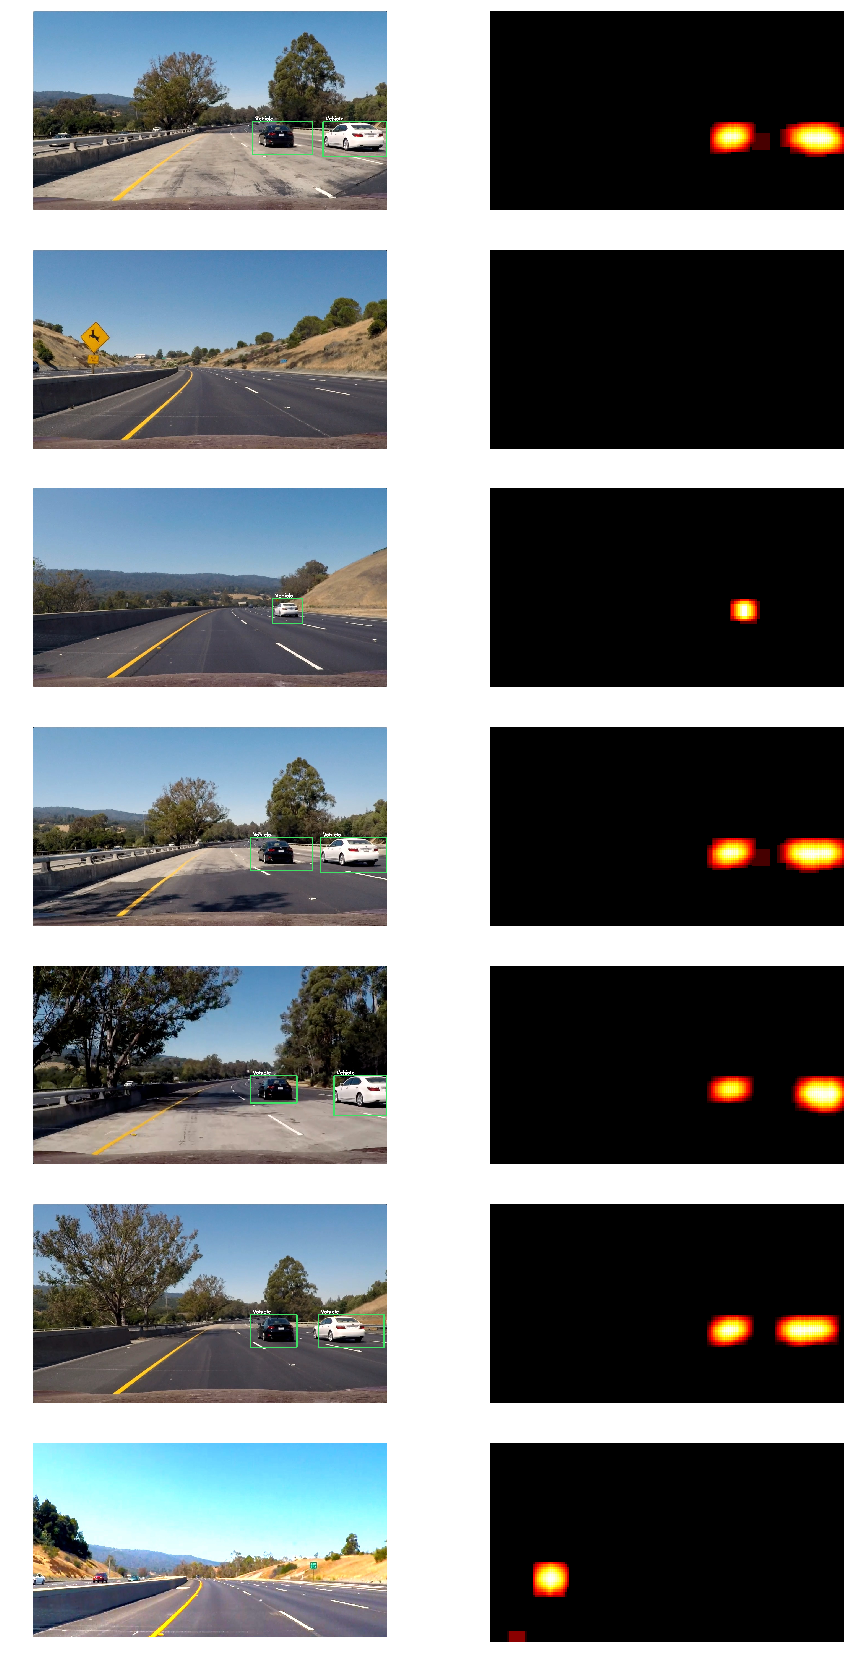

In [158]:
%matplotlib inline

sample_images = []
images = glob.glob('C:\\data\\detection\\templates\\test*.jpg')

for fname in images:
    img = mpimg.imread(fname)
    previous_boxes=[]
    output, heatmap = detect_vehicles(img)
    sample_images.append(output)
    sample_images.append(heatmap)
    
plt.figure(figsize=(15, 30))
for i in range(len(sample_images)):
    plt.subplot(7, 2, i+1)
    plt.imshow(sample_images[i]) 
    plt.axis('off')

In [148]:
# Test the pipeline for videos
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = ('C:\\data\\detection\\project_video_output.mp4')
clip1 = VideoFileClip("C:\\data\\detection\\project_video.mp4")
white_clip = clip1.fl_image(detect_vehicles).subclip(3,8)
%time white_clip.write_videofile(white_output, audio=False)
clip1.reader.close()
clip1.audio.reader.close_proc()

[[769, 400, 953, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1279, 527], [763, 400, 954, 518], [1048, 400, 1279, 527], [785, 400, 954, 518], [1015, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 95

  0%|          | 0/126 [00:00<?, ?it/s]

[[769, 400, 953, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1279, 527], [763, 400, 954, 518], [1048, 400, 1279, 527], [785, 400, 954, 518], [1015, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 95

  1%|          | 1/126 [00:01<02:40,  1.29s/it]

[[769, 400, 953, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1279, 527], [763, 400, 954, 518], [1048, 400, 1279, 527], [785, 400, 954, 518], [1015, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 95

  2%|▏         | 2/126 [00:02<02:23,  1.16s/it]

[[769, 400, 953, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1279, 527], [763, 400, 954, 518], [1048, 400, 1279, 527], [785, 400, 954, 518], [1015, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 95

  2%|▏         | 3/126 [00:03<02:17,  1.12s/it]

[[769, 400, 953, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1279, 527], [763, 400, 954, 518], [1048, 400, 1279, 527], [785, 400, 954, 518], [1015, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 95

  3%|▎         | 4/126 [00:04<02:12,  1.09s/it]

[[769, 400, 953, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1279, 527], [763, 400, 954, 518], [1048, 400, 1279, 527], [785, 400, 954, 518], [1015, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 95

  4%|▍         | 5/126 [00:05<02:04,  1.03s/it]

[[769, 400, 953, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1279, 527], [763, 400, 954, 518], [1048, 400, 1279, 527], [785, 400, 954, 518], [1015, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 95

  5%|▍         | 6/126 [00:06<01:59,  1.00it/s]

[[769, 400, 953, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1279, 527], [763, 400, 954, 518], [1048, 400, 1279, 527], [785, 400, 954, 518], [1015, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 95

  6%|▌         | 7/126 [00:06<01:58,  1.01it/s]

[[769, 400, 953, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1279, 527], [763, 400, 954, 518], [1048, 400, 1279, 527], [785, 400, 954, 518], [1015, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 95

  6%|▋         | 8/126 [00:07<01:55,  1.02it/s]

[[769, 400, 953, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1279, 527], [763, 400, 954, 518], [1048, 400, 1279, 527], [785, 400, 954, 518], [1015, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 95

  7%|▋         | 9/126 [00:08<01:51,  1.05it/s]

[[769, 400, 953, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1279, 527], [763, 400, 954, 518], [1048, 400, 1279, 527], [785, 400, 954, 518], [1015, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 95

  8%|▊         | 10/126 [00:09<01:46,  1.09it/s]

[[769, 400, 953, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1279, 527], [763, 400, 954, 518], [1048, 400, 1279, 527], [785, 400, 954, 518], [1015, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 95

  9%|▊         | 11/126 [00:10<01:42,  1.12it/s]

[[769, 400, 953, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1279, 527], [763, 400, 954, 518], [1048, 400, 1279, 527], [785, 400, 954, 518], [1015, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 95

 10%|▉         | 12/126 [00:11<01:39,  1.14it/s]

[[769, 400, 953, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1279, 527], [763, 400, 954, 518], [1048, 400, 1279, 527], [785, 400, 954, 518], [1015, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 95

 10%|█         | 13/126 [00:12<01:38,  1.15it/s]

[[769, 400, 953, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1279, 527], [763, 400, 954, 518], [1048, 400, 1279, 527], [785, 400, 954, 518], [1015, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 95

 11%|█         | 14/126 [00:13<01:35,  1.17it/s]

[[769, 400, 953, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1279, 527], [763, 400, 954, 518], [1048, 400, 1279, 527], [785, 400, 954, 518], [1015, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 95

 12%|█▏        | 15/126 [00:13<01:36,  1.15it/s]

[[769, 400, 953, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1279, 527], [763, 400, 954, 518], [1048, 400, 1279, 527], [785, 400, 954, 518], [1015, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 95

 13%|█▎        | 16/126 [00:14<01:38,  1.12it/s]

[[769, 400, 953, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1279, 527], [763, 400, 954, 518], [1048, 400, 1279, 527], [785, 400, 954, 518], [1015, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 95

 13%|█▎        | 17/126 [00:15<01:37,  1.12it/s]

[[769, 400, 953, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1279, 527], [763, 400, 954, 518], [1048, 400, 1279, 527], [785, 400, 954, 518], [1015, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 95

 14%|█▍        | 18/126 [00:16<01:34,  1.14it/s]

[[769, 400, 953, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1279, 527], [763, 400, 954, 518], [1048, 400, 1279, 527], [785, 400, 954, 518], [1015, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 95

 15%|█▌        | 19/126 [00:17<01:31,  1.17it/s]

[[769, 400, 953, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1279, 527], [763, 400, 954, 518], [1048, 400, 1279, 527], [785, 400, 954, 518], [1015, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 95

 16%|█▌        | 20/126 [00:18<01:29,  1.18it/s]

[[769, 400, 953, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1279, 527], [763, 400, 954, 518], [1048, 400, 1279, 527], [785, 400, 954, 518], [1015, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 95

 17%|█▋        | 21/126 [00:19<01:31,  1.14it/s]

[[769, 400, 953, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1279, 527], [763, 400, 954, 518], [1048, 400, 1279, 527], [785, 400, 954, 518], [1015, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 95

 17%|█▋        | 22/126 [00:20<01:33,  1.11it/s]

[[769, 400, 953, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1279, 527], [763, 400, 954, 518], [1048, 400, 1279, 527], [785, 400, 954, 518], [1015, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 95

 18%|█▊        | 23/126 [00:21<01:33,  1.10it/s]

[[769, 400, 953, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1279, 527], [763, 400, 954, 518], [1048, 400, 1279, 527], [785, 400, 954, 518], [1015, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 95

 19%|█▉        | 24/126 [00:22<01:34,  1.08it/s]

[[769, 400, 953, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1279, 527], [763, 400, 954, 518], [1048, 400, 1279, 527], [785, 400, 954, 518], [1015, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 95

 20%|█▉        | 25/126 [00:22<01:33,  1.07it/s]

[[769, 400, 953, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1279, 527], [763, 400, 954, 518], [1048, 400, 1279, 527], [785, 400, 954, 518], [1015, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 95

 21%|██        | 26/126 [00:23<01:32,  1.08it/s]

[[769, 400, 953, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1279, 527], [763, 400, 954, 518], [1048, 400, 1279, 527], [785, 400, 954, 518], [1015, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 95

 21%|██▏       | 27/126 [00:24<01:29,  1.11it/s]

[[769, 400, 953, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1279, 527], [763, 400, 954, 518], [1048, 400, 1279, 527], [785, 400, 954, 518], [1015, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 95

 22%|██▏       | 28/126 [00:25<01:26,  1.14it/s]

[[769, 400, 953, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1279, 527], [763, 400, 954, 518], [1048, 400, 1279, 527], [785, 400, 954, 518], [1015, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 95

 23%|██▎       | 29/126 [00:26<01:23,  1.17it/s]

[[769, 400, 953, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1279, 527], [763, 400, 954, 518], [1048, 400, 1279, 527], [785, 400, 954, 518], [1015, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 95

 24%|██▍       | 30/126 [00:27<01:20,  1.19it/s]

[[769, 400, 953, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1279, 527], [763, 400, 954, 518], [1048, 400, 1279, 527], [785, 400, 954, 518], [1015, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 95

 25%|██▍       | 31/126 [00:27<01:19,  1.20it/s]

[[769, 400, 953, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1279, 527], [763, 400, 954, 518], [1048, 400, 1279, 527], [785, 400, 954, 518], [1015, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 95

 25%|██▌       | 32/126 [00:28<01:17,  1.21it/s]

[[769, 400, 953, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1279, 527], [763, 400, 954, 518], [1048, 400, 1279, 527], [785, 400, 954, 518], [1015, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 95

 26%|██▌       | 33/126 [00:29<01:16,  1.22it/s]

[[769, 400, 953, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1279, 527], [763, 400, 954, 518], [1048, 400, 1279, 527], [785, 400, 954, 518], [1015, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 95

 27%|██▋       | 34/126 [00:30<01:15,  1.22it/s]

[[769, 400, 953, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1279, 527], [763, 400, 954, 518], [1048, 400, 1279, 527], [785, 400, 954, 518], [1015, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 95

 28%|██▊       | 35/126 [00:31<01:14,  1.23it/s]

[[769, 400, 953, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1279, 527], [763, 400, 954, 518], [1048, 400, 1279, 527], [785, 400, 954, 518], [1015, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 95

 29%|██▊       | 36/126 [00:32<01:13,  1.23it/s]

[[769, 400, 953, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1279, 527], [763, 400, 954, 518], [1048, 400, 1279, 527], [785, 400, 954, 518], [1015, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 95

 29%|██▉       | 37/126 [00:32<01:12,  1.23it/s]

[[769, 400, 953, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1279, 527], [763, 400, 954, 518], [1048, 400, 1279, 527], [785, 400, 954, 518], [1015, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 95

 30%|███       | 38/126 [00:33<01:11,  1.23it/s]

[[769, 400, 953, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1279, 527], [763, 400, 954, 518], [1048, 400, 1279, 527], [785, 400, 954, 518], [1015, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 95

 31%|███       | 39/126 [00:34<01:11,  1.22it/s]

[[769, 400, 953, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1279, 527], [763, 400, 954, 518], [1048, 400, 1279, 527], [785, 400, 954, 518], [1015, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 95

 32%|███▏      | 40/126 [00:35<01:12,  1.18it/s]

[[769, 400, 953, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1279, 527], [763, 400, 954, 518], [1048, 400, 1279, 527], [785, 400, 954, 518], [1015, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 95

 33%|███▎      | 41/126 [00:36<01:13,  1.15it/s]

[[1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1279, 527], [763, 400, 954, 518], [1048, 400, 1279, 527], [785, 400, 954, 518], [1015, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 955, 513], [1056, 400, 1

 33%|███▎      | 42/126 [00:37<01:14,  1.13it/s]

[[1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1279, 527], [763, 400, 954, 518], [1048, 400, 1279, 527], [785, 400, 954, 518], [1015, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 955, 513], [1056, 400, 1

 34%|███▍      | 43/126 [00:38<01:15,  1.09it/s]

[[1047, 400, 1278, 527], [785, 400, 954, 518], [1047, 400, 1279, 527], [763, 400, 954, 518], [1048, 400, 1279, 527], [785, 400, 954, 518], [1015, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 955, 513], [1056, 400, 1279, 527], [1232, 480, 1279, 552], [253, 400, 

 35%|███▍      | 44/126 [00:39<01:15,  1.08it/s]

[[1047, 400, 1279, 527], [763, 400, 954, 518], [1048, 400, 1279, 527], [785, 400, 954, 518], [1015, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 955, 513], [1056, 400, 1279, 527], [1232, 480, 1279, 552], [253, 400, 323, 463], [1223, 480, 1279, 552], [219, 400, 

 36%|███▌      | 45/126 [00:40<01:14,  1.09it/s]

[[1048, 400, 1279, 527], [785, 400, 954, 518], [1015, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 955, 513], [1056, 400, 1279, 527], [1232, 480, 1279, 552], [253, 400, 323, 463], [1223, 480, 1279, 552], [219, 400, 322, 463], [1240, 460, 1279, 550], [211, 400, 

 37%|███▋      | 46/126 [00:40<01:12,  1.11it/s]

[[1015, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 955, 513], [1056, 400, 1279, 527], [1232, 480, 1279, 552], [253, 400, 323, 463], [1223, 480, 1279, 552], [219, 400, 322, 463], [1240, 460, 1279, 550], [211, 400, 314, 463], [1240, 450, 1279, 549], [202, 400, 

 37%|███▋      | 47/126 [00:41<01:11,  1.11it/s]

[[1023, 400, 1279, 527], [10, 470, 81, 533], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 955, 513], [1056, 400, 1279, 527], [1232, 480, 1279, 552], [253, 400, 323, 463], [1223, 480, 1279, 552], [219, 400, 322, 463], [1240, 460, 1279, 550], [211, 400, 314, 463], [1240, 450, 1279, 549], [202, 400, 306, 463], [1216, 430, 1279, 557], [194, 400, 

 38%|███▊      | 48/126 [00:42<01:10,  1.11it/s]

[[785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 955, 513], [1056, 400, 1279, 527], [1232, 480, 1279, 552], [253, 400, 323, 463], [1223, 480, 1279, 552], [219, 400, 322, 463], [1240, 460, 1279, 550], [211, 400, 314, 463], [1240, 450, 1279, 549], [202, 400, 306, 463], [1216, 430, 1279, 557], [194, 400, 298, 463], [1232, 430, 1279, 548], [186, 400

 39%|███▉      | 49/126 [00:43<01:09,  1.11it/s]

[[785, 400, 954, 518], [1023, 400, 1279, 527], [785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 955, 513], [1056, 400, 1279, 527], [1232, 480, 1279, 552], [253, 400, 323, 463], [1223, 480, 1279, 552], [219, 400, 322, 463], [1240, 460, 1279, 550], [211, 400, 314, 463], [1240, 450, 1279, 549], [202, 400, 306, 463], [1216, 430, 1279, 557], [194, 400, 298, 463], [1232, 430, 1279, 548], [186, 400, 289, 463], [1232, 430, 1279, 557], [180, 400

 40%|███▉      | 50/126 [00:44<01:08,  1.11it/s]

[[785, 400, 954, 518], [1030, 400, 1279, 527], [785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 955, 513], [1056, 400, 1279, 527], [1232, 480, 1279, 552], [253, 400, 323, 463], [1223, 480, 1279, 552], [219, 400, 322, 463], [1240, 460, 1279, 550], [211, 400, 314, 463], [1240, 450, 1279, 549], [202, 400, 306, 463], [1216, 430, 1279, 557], [194, 400, 298, 463], [1232, 430, 1279, 548], [186, 400, 289, 463], [1232, 430, 1279, 557], [180, 400, 288, 463], [1232, 430, 1279, 548], [164, 400

 40%|████      | 51/126 [00:45<01:08,  1.10it/s]

[[785, 400, 954, 518], [1023, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 955, 513], [1056, 400, 1279, 527], [1232, 480, 1279, 552], [253, 400, 323, 463], [1223, 480, 1279, 552], [219, 400, 322, 463], [1240, 460, 1279, 550], [211, 400, 314, 463], [1240, 450, 1279, 549], [202, 400, 306, 463], [1216, 430, 1279, 557], [194, 400, 298, 463], [1232, 430, 1279, 548], [186, 400, 289, 463], [1232, 430, 1279, 557], [180, 400, 288, 463], [1232, 430, 1279, 548], [164, 400, 279, 463], [1224, 420, 1279, 556], [155, 400

 41%|████▏     | 52/126 [00:46<01:08,  1.08it/s]

[[786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 955, 513], [1056, 400, 1279, 527], [1232, 480, 1279, 552], [253, 400, 323, 463], [1223, 480, 1279, 552], [219, 400, 322, 463], [1240, 460, 1279, 550], [211, 400, 314, 463], [1240, 450, 1279, 549], [202, 400, 306, 463], [1216, 430, 1279, 557], [194, 400, 298, 463], [1232, 430, 1279, 548], [186, 400, 289, 463], [1232, 430, 1279, 557], [180, 400, 288, 463], [1232, 430, 1279, 548], [164, 400, 279, 463], [1224, 420, 1279, 556], [155, 400, 270, 463], [1224, 420, 1279, 556], [138, 400

 42%|████▏     | 53/126 [00:47<01:09,  1.06it/s]

[[786, 400, 970, 518], [1039, 400, 1279, 527], [786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 955, 513], [1056, 400, 1279, 527], [1232, 480, 1279, 552], [253, 400, 323, 463], [1223, 480, 1279, 552], [219, 400, 322, 463], [1240, 460, 1279, 550], [211, 400, 314, 463], [1240, 450, 1279, 549], [202, 400, 306, 463], [1216, 430, 1279, 557], [194, 400, 298, 463], [1232, 430, 1279, 548], [186, 400, 289, 463], [1232, 430, 1279, 557], [180, 400, 288, 463], [1232, 430, 1279, 548], [164, 400, 279, 463], [1224, 420, 1279, 556], [155, 400, 270, 463], [1224, 420, 1279, 556], [138, 400, 254, 463], [1216, 420, 1279, 547], [122, 400

 43%|████▎     | 54/126 [00:48<01:10,  1.03it/s]

[[786, 400, 970, 518], [1031, 400, 1279, 527], [786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 955, 513], [1056, 400, 1279, 527], [1232, 480, 1279, 552], [253, 400, 323, 463], [1223, 480, 1279, 552], [219, 400, 322, 463], [1240, 460, 1279, 550], [211, 400, 314, 463], [1240, 450, 1279, 549], [202, 400, 306, 463], [1216, 430, 1279, 557], [194, 400, 298, 463], [1232, 430, 1279, 548], [186, 400, 289, 463], [1232, 430, 1279, 557], [180, 400, 288, 463], [1232, 430, 1279, 548], [164, 400, 279, 463], [1224, 420, 1279, 556], [155, 400, 270, 463], [1224, 420, 1279, 556], [138, 400, 254, 463], [1216, 420, 1279, 547], [122, 400, 245, 472], [1192, 420, 1279, 556], [113, 400

 44%|████▎     | 55/126 [00:49<01:10,  1.01it/s]

[[786, 400, 970, 518], [1039, 400, 1279, 527], [802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 955, 513], [1056, 400, 1279, 527], [1232, 480, 1279, 552], [253, 400, 323, 463], [1223, 480, 1279, 552], [219, 400, 322, 463], [1240, 460, 1279, 550], [211, 400, 314, 463], [1240, 450, 1279, 549], [202, 400, 306, 463], [1216, 430, 1279, 557], [194, 400, 298, 463], [1232, 430, 1279, 548], [186, 400, 289, 463], [1232, 430, 1279, 557], [180, 400, 288, 463], [1232, 430, 1279, 548], [164, 400, 279, 463], [1224, 420, 1279, 556], [155, 400, 270, 463], [1224, 420, 1279, 556], [138, 400, 254, 463], [1216, 420, 1279, 547], [122, 400, 245, 472], [1192, 420, 1279, 556], [113, 400, 229, 472], [1208, 410, 1279, 555], [97, 400,

 44%|████▍     | 56/126 [00:50<01:12,  1.03s/it]

[[802, 400, 971, 508], [1031, 400, 1279, 527], [780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 955, 513], [1056, 400, 1279, 527], [1232, 480, 1279, 552], [253, 400, 323, 463], [1223, 480, 1279, 552], [219, 400, 322, 463], [1240, 460, 1279, 550], [211, 400, 314, 463], [1240, 450, 1279, 549], [202, 400, 306, 463], [1216, 430, 1279, 557], [194, 400, 298, 463], [1232, 430, 1279, 548], [186, 400, 289, 463], [1232, 430, 1279, 557], [180, 400, 288, 463], [1232, 430, 1279, 548], [164, 400, 279, 463], [1224, 420, 1279, 556], [155, 400, 270, 463], [1224, 420, 1279, 556], [138, 400, 254, 463], [1216, 420, 1279, 547], [122, 400, 245, 472], [1192, 420, 1279, 556], [113, 400, 229, 472], [1208, 410, 1279, 555], [97, 400, 212, 472], [1200, 410, 1279, 555], [80, 400, 

 45%|████▌     | 57/126 [00:51<01:14,  1.07s/it]

[[780, 400, 971, 512], [1039, 400, 1279, 527], [780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 955, 513], [1056, 400, 1279, 527], [1232, 480, 1279, 552], [253, 400, 323, 463], [1223, 480, 1279, 552], [219, 400, 322, 463], [1240, 460, 1279, 550], [211, 400, 314, 463], [1240, 450, 1279, 549], [202, 400, 306, 463], [1216, 430, 1279, 557], [194, 400, 298, 463], [1232, 430, 1279, 548], [186, 400, 289, 463], [1232, 430, 1279, 557], [180, 400, 288, 463], [1232, 430, 1279, 548], [164, 400, 279, 463], [1224, 420, 1279, 556], [155, 400, 270, 463], [1224, 420, 1279, 556], [138, 400, 254, 463], [1216, 420, 1279, 547], [122, 400, 245, 472], [1192, 420, 1279, 556], [113, 400, 229, 472], [1208, 410, 1279, 555], [97, 400, 212, 472], [1200, 410, 1279, 555], [80, 400, 203, 472], [1200, 410, 1279, 555], [56, 400, 1

 46%|████▌     | 58/126 [00:52<01:14,  1.10s/it]

[[780, 400, 955, 513], [1031, 400, 1279, 527], [801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 955, 513], [1056, 400, 1279, 527], [1232, 480, 1279, 552], [253, 400, 323, 463], [1223, 480, 1279, 552], [219, 400, 322, 463], [1240, 460, 1279, 550], [211, 400, 314, 463], [1240, 450, 1279, 549], [202, 400, 306, 463], [1216, 430, 1279, 557], [194, 400, 298, 463], [1232, 430, 1279, 548], [186, 400, 289, 463], [1232, 430, 1279, 557], [180, 400, 288, 463], [1232, 430, 1279, 548], [164, 400, 279, 463], [1224, 420, 1279, 556], [155, 400, 270, 463], [1224, 420, 1279, 556], [138, 400, 254, 463], [1216, 420, 1279, 547], [122, 400, 245, 472], [1192, 420, 1279, 556], [113, 400, 229, 472], [1208, 410, 1279, 555], [97, 400, 212, 472], [1200, 410, 1279, 555], [80, 400, 203, 472], [1200, 410, 1279, 555], [56, 400, 186, 472], [1200, 410, 1279, 555], [39, 400, 16

 47%|████▋     | 59/126 [00:54<01:16,  1.14s/it]

[[801, 400, 955, 508], [1014, 400, 1279, 527], [780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 955, 513], [1056, 400, 1279, 527], [1232, 480, 1279, 552], [253, 400, 323, 463], [1223, 480, 1279, 552], [219, 400, 322, 463], [1240, 460, 1279, 550], [211, 400, 314, 463], [1240, 450, 1279, 549], [202, 400, 306, 463], [1216, 430, 1279, 557], [194, 400, 298, 463], [1232, 430, 1279, 548], [186, 400, 289, 463], [1232, 430, 1279, 557], [180, 400, 288, 463], [1232, 430, 1279, 548], [164, 400, 279, 463], [1224, 420, 1279, 556], [155, 400, 270, 463], [1224, 420, 1279, 556], [138, 400, 254, 463], [1216, 420, 1279, 547], [122, 400, 245, 472], [1192, 420, 1279, 556], [113, 400, 229, 472], [1208, 410, 1279, 555], [97, 400, 212, 472], [1200, 410, 1279, 555], [80, 400, 203, 472], [1200, 410, 1279, 555], [56, 400, 186, 472], [1200, 410, 1279, 555], [39, 400, 169, 472], [1173, 410, 1279, 555], [14, 400, 144

 48%|████▊     | 60/126 [00:55<01:15,  1.14s/it]

[[780, 400, 955, 518], [1039, 400, 1279, 536], [801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 955, 513], [1056, 400, 1279, 527], [1232, 480, 1279, 552], [253, 400, 323, 463], [1223, 480, 1279, 552], [219, 400, 322, 463], [1240, 460, 1279, 550], [211, 400, 314, 463], [1240, 450, 1279, 549], [202, 400, 306, 463], [1216, 430, 1279, 557], [194, 400, 298, 463], [1232, 430, 1279, 548], [186, 400, 289, 463], [1232, 430, 1279, 557], [180, 400, 288, 463], [1232, 430, 1279, 548], [164, 400, 279, 463], [1224, 420, 1279, 556], [155, 400, 270, 463], [1224, 420, 1279, 556], [138, 400, 254, 463], [1216, 420, 1279, 547], [122, 400, 245, 472], [1192, 420, 1279, 556], [113, 400, 229, 472], [1208, 410, 1279, 555], [97, 400, 212, 472], [1200, 410, 1279, 555], [80, 400, 203, 472], [1200, 410, 1279, 555], [56, 400, 186, 472], [1200, 410, 1279, 555], [39, 400, 169, 472], [1173, 410, 1279, 555], [14, 400, 144, 472], [1200, 410, 1279, 546], [4, 400, 127, 

 48%|████▊     | 61/126 [00:56<01:13,  1.12s/it]

[[801, 400, 955, 518], [1047, 400, 1279, 536], [785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 955, 513], [1056, 400, 1279, 527], [1232, 480, 1279, 552], [253, 400, 323, 463], [1223, 480, 1279, 552], [219, 400, 322, 463], [1240, 460, 1279, 550], [211, 400, 314, 463], [1240, 450, 1279, 549], [202, 400, 306, 463], [1216, 430, 1279, 557], [194, 400, 298, 463], [1232, 430, 1279, 548], [186, 400, 289, 463], [1232, 430, 1279, 557], [180, 400, 288, 463], [1232, 430, 1279, 548], [164, 400, 279, 463], [1224, 420, 1279, 556], [155, 400, 270, 463], [1224, 420, 1279, 556], [138, 400, 254, 463], [1216, 420, 1279, 547], [122, 400, 245, 472], [1192, 420, 1279, 556], [113, 400, 229, 472], [1208, 410, 1279, 555], [97, 400, 212, 472], [1200, 410, 1279, 555], [80, 400, 203, 472], [1200, 410, 1279, 555], [56, 400, 186, 472], [1200, 410, 1279, 555], [39, 400, 169, 472], [1173, 410, 1279, 555], [14, 400, 144, 472], [1200, 410, 1279, 546], [4, 400, 127, 472], [1200, 410, 1279, 546], [1, 400, 94, 472

 49%|████▉     | 62/126 [00:57<01:11,  1.12s/it]

[[785, 400, 954, 518], [1055, 400, 1278, 527], [780, 400, 955, 513], [1056, 400, 1279, 527], [1232, 480, 1279, 552], [253, 400, 323, 463], [1223, 480, 1279, 552], [219, 400, 322, 463], [1240, 460, 1279, 550], [211, 400, 314, 463], [1240, 450, 1279, 549], [202, 400, 306, 463], [1216, 430, 1279, 557], [194, 400, 298, 463], [1232, 430, 1279, 548], [186, 400, 289, 463], [1232, 430, 1279, 557], [180, 400, 288, 463], [1232, 430, 1279, 548], [164, 400, 279, 463], [1224, 420, 1279, 556], [155, 400, 270, 463], [1224, 420, 1279, 556], [138, 400, 254, 463], [1216, 420, 1279, 547], [122, 400, 245, 472], [1192, 420, 1279, 556], [113, 400, 229, 472], [1208, 410, 1279, 555], [97, 400, 212, 472], [1200, 410, 1279, 555], [80, 400, 203, 472], [1200, 410, 1279, 555], [56, 400, 186, 472], [1200, 410, 1279, 555], [39, 400, 169, 472], [1173, 410, 1279, 555], [14, 400, 144, 472], [1200, 410, 1279, 546], [4, 400, 127, 472], [1200, 410, 1279, 546], [1, 400, 94, 472], [1192, 410, 1279, 546], [0, 400, 71, 472], 

 50%|█████     | 63/126 [00:58<01:10,  1.11s/it]

[[1055, 400, 1278, 527], [780, 400, 955, 513], [1056, 400, 1279, 527], [1232, 480, 1279, 552], [253, 400, 323, 463], [1223, 480, 1279, 552], [219, 400, 322, 463], [1240, 460, 1279, 550], [211, 400, 314, 463], [1240, 450, 1279, 549], [202, 400, 306, 463], [1216, 430, 1279, 557], [194, 400, 298, 463], [1232, 430, 1279, 548], [186, 400, 289, 463], [1232, 430, 1279, 557], [180, 400, 288, 463], [1232, 430, 1279, 548], [164, 400, 279, 463], [1224, 420, 1279, 556], [155, 400, 270, 463], [1224, 420, 1279, 556], [138, 400, 254, 463], [1216, 420, 1279, 547], [122, 400, 245, 472], [1192, 420, 1279, 556], [113, 400, 229, 472], [1208, 410, 1279, 555], [97, 400, 212, 472], [1200, 410, 1279, 555], [80, 400, 203, 472], [1200, 410, 1279, 555], [56, 400, 186, 472], [1200, 410, 1279, 555], [39, 400, 169, 472], [1173, 410, 1279, 555], [14, 400, 144, 472], [1200, 410, 1279, 546], [4, 400, 127, 472], [1200, 410, 1279, 546], [1, 400, 94, 472], [1192, 410, 1279, 546], [0, 400, 71, 472], [1184, 400, 1279, 545]

 51%|█████     | 64/126 [00:59<01:09,  1.12s/it]

[[780, 400, 955, 513], [1056, 400, 1279, 527], [1232, 480, 1279, 552], [253, 400, 323, 463], [1223, 480, 1279, 552], [219, 400, 322, 463], [1240, 460, 1279, 550], [211, 400, 314, 463], [1240, 450, 1279, 549], [202, 400, 306, 463], [1216, 430, 1279, 557], [194, 400, 298, 463], [1232, 430, 1279, 548], [186, 400, 289, 463], [1232, 430, 1279, 557], [180, 400, 288, 463], [1232, 430, 1279, 548], [164, 400, 279, 463], [1224, 420, 1279, 556], [155, 400, 270, 463], [1224, 420, 1279, 556], [138, 400, 254, 463], [1216, 420, 1279, 547], [122, 400, 245, 472], [1192, 420, 1279, 556], [113, 400, 229, 472], [1208, 410, 1279, 555], [97, 400, 212, 472], [1200, 410, 1279, 555], [80, 400, 203, 472], [1200, 410, 1279, 555], [56, 400, 186, 472], [1200, 410, 1279, 555], [39, 400, 169, 472], [1173, 410, 1279, 555], [14, 400, 144, 472], [1200, 410, 1279, 546], [4, 400, 127, 472], [1200, 410, 1279, 546], [1, 400, 94, 472], [1192, 410, 1279, 546], [0, 400, 71, 472], [1184, 400, 1279, 545], [1184, 400, 1279, 545]

 52%|█████▏    | 65/126 [01:00<01:09,  1.13s/it]

[[1056, 400, 1279, 527], [1232, 480, 1279, 552], [253, 400, 323, 463], [1223, 480, 1279, 552], [219, 400, 322, 463], [1240, 460, 1279, 550], [211, 400, 314, 463], [1240, 450, 1279, 549], [202, 400, 306, 463], [1216, 430, 1279, 557], [194, 400, 298, 463], [1232, 430, 1279, 548], [186, 400, 289, 463], [1232, 430, 1279, 557], [180, 400, 288, 463], [1232, 430, 1279, 548], [164, 400, 279, 463], [1224, 420, 1279, 556], [155, 400, 270, 463], [1224, 420, 1279, 556], [138, 400, 254, 463], [1216, 420, 1279, 547], [122, 400, 245, 472], [1192, 420, 1279, 556], [113, 400, 229, 472], [1208, 410, 1279, 555], [97, 400, 212, 472], [1200, 410, 1279, 555], [80, 400, 203, 472], [1200, 410, 1279, 555], [56, 400, 186, 472], [1200, 410, 1279, 555], [39, 400, 169, 472], [1173, 410, 1279, 555], [14, 400, 144, 472], [1200, 410, 1279, 546], [4, 400, 127, 472], [1200, 410, 1279, 546], [1, 400, 94, 472], [1192, 410, 1279, 546], [0, 400, 71, 472], [1184, 400, 1279, 545], [1184, 400, 1279, 545], [1156, 400, 1279, 54

 52%|█████▏    | 66/126 [01:02<01:07,  1.13s/it]

[[1232, 480, 1279, 552], [253, 400, 323, 463], [1223, 480, 1279, 552], [219, 400, 322, 463], [1240, 460, 1279, 550], [211, 400, 314, 463], [1240, 450, 1279, 549], [202, 400, 306, 463], [1216, 430, 1279, 557], [194, 400, 298, 463], [1232, 430, 1279, 548], [186, 400, 289, 463], [1232, 430, 1279, 557], [180, 400, 288, 463], [1232, 430, 1279, 548], [164, 400, 279, 463], [1224, 420, 1279, 556], [155, 400, 270, 463], [1224, 420, 1279, 556], [138, 400, 254, 463], [1216, 420, 1279, 547], [122, 400, 245, 472], [1192, 420, 1279, 556], [113, 400, 229, 472], [1208, 410, 1279, 555], [97, 400, 212, 472], [1200, 410, 1279, 555], [80, 400, 203, 472], [1200, 410, 1279, 555], [56, 400, 186, 472], [1200, 410, 1279, 555], [39, 400, 169, 472], [1173, 410, 1279, 555], [14, 400, 144, 472], [1200, 410, 1279, 546], [4, 400, 127, 472], [1200, 410, 1279, 546], [1, 400, 94, 472], [1192, 410, 1279, 546], [0, 400, 71, 472], [1184, 400, 1279, 545], [1184, 400, 1279, 545], [1156, 400, 1279, 545], [1176, 400, 1279, 54

 53%|█████▎    | 67/126 [01:03<01:05,  1.12s/it]

[[253, 400, 323, 463], [1223, 480, 1279, 552], [219, 400, 322, 463], [1240, 460, 1279, 550], [211, 400, 314, 463], [1240, 450, 1279, 549], [202, 400, 306, 463], [1216, 430, 1279, 557], [194, 400, 298, 463], [1232, 430, 1279, 548], [186, 400, 289, 463], [1232, 430, 1279, 557], [180, 400, 288, 463], [1232, 430, 1279, 548], [164, 400, 279, 463], [1224, 420, 1279, 556], [155, 400, 270, 463], [1224, 420, 1279, 556], [138, 400, 254, 463], [1216, 420, 1279, 547], [122, 400, 245, 472], [1192, 420, 1279, 556], [113, 400, 229, 472], [1208, 410, 1279, 555], [97, 400, 212, 472], [1200, 410, 1279, 555], [80, 400, 203, 472], [1200, 410, 1279, 555], [56, 400, 186, 472], [1200, 410, 1279, 555], [39, 400, 169, 472], [1173, 410, 1279, 555], [14, 400, 144, 472], [1200, 410, 1279, 546], [4, 400, 127, 472], [1200, 410, 1279, 546], [1, 400, 94, 472], [1192, 410, 1279, 546], [0, 400, 71, 472], [1184, 400, 1279, 545], [1184, 400, 1279, 545], [1156, 400, 1279, 545], [1176, 400, 1279, 545], [1176, 410, 1279, 54

 54%|█████▍    | 68/126 [01:04<01:05,  1.12s/it]

[[1223, 480, 1279, 552], [219, 400, 322, 463], [1240, 460, 1279, 550], [211, 400, 314, 463], [1240, 450, 1279, 549], [202, 400, 306, 463], [1216, 430, 1279, 557], [194, 400, 298, 463], [1232, 430, 1279, 548], [186, 400, 289, 463], [1232, 430, 1279, 557], [180, 400, 288, 463], [1232, 430, 1279, 548], [164, 400, 279, 463], [1224, 420, 1279, 556], [155, 400, 270, 463], [1224, 420, 1279, 556], [138, 400, 254, 463], [1216, 420, 1279, 547], [122, 400, 245, 472], [1192, 420, 1279, 556], [113, 400, 229, 472], [1208, 410, 1279, 555], [97, 400, 212, 472], [1200, 410, 1279, 555], [80, 400, 203, 472], [1200, 410, 1279, 555], [56, 400, 186, 472], [1200, 410, 1279, 555], [39, 400, 169, 472], [1173, 410, 1279, 555], [14, 400, 144, 472], [1200, 410, 1279, 546], [4, 400, 127, 472], [1200, 410, 1279, 546], [1, 400, 94, 472], [1192, 410, 1279, 546], [0, 400, 71, 472], [1184, 400, 1279, 545], [1184, 400, 1279, 545], [1156, 400, 1279, 545], [1176, 400, 1279, 545], [1176, 410, 1279, 546], [1148, 410, 1279, 

 55%|█████▍    | 69/126 [01:05<01:02,  1.10s/it]

[[219, 400, 322, 463], [1240, 460, 1279, 550], [211, 400, 314, 463], [1240, 450, 1279, 549], [202, 400, 306, 463], [1216, 430, 1279, 557], [194, 400, 298, 463], [1232, 430, 1279, 548], [186, 400, 289, 463], [1232, 430, 1279, 557], [180, 400, 288, 463], [1232, 430, 1279, 548], [164, 400, 279, 463], [1224, 420, 1279, 556], [155, 400, 270, 463], [1224, 420, 1279, 556], [138, 400, 254, 463], [1216, 420, 1279, 547], [122, 400, 245, 472], [1192, 420, 1279, 556], [113, 400, 229, 472], [1208, 410, 1279, 555], [97, 400, 212, 472], [1200, 410, 1279, 555], [80, 400, 203, 472], [1200, 410, 1279, 555], [56, 400, 186, 472], [1200, 410, 1279, 555], [39, 400, 169, 472], [1173, 410, 1279, 555], [14, 400, 144, 472], [1200, 410, 1279, 546], [4, 400, 127, 472], [1200, 410, 1279, 546], [1, 400, 94, 472], [1192, 410, 1279, 546], [0, 400, 71, 472], [1184, 400, 1279, 545], [1184, 400, 1279, 545], [1156, 400, 1279, 545], [1176, 400, 1279, 545], [1176, 410, 1279, 546], [1148, 410, 1279, 546], [1168, 410, 1279, 

 56%|█████▌    | 70/126 [01:06<01:02,  1.12s/it]

[[1240, 460, 1279, 550], [211, 400, 314, 463], [1240, 450, 1279, 549], [202, 400, 306, 463], [1216, 430, 1279, 557], [194, 400, 298, 463], [1232, 430, 1279, 548], [186, 400, 289, 463], [1232, 430, 1279, 557], [180, 400, 288, 463], [1232, 430, 1279, 548], [164, 400, 279, 463], [1224, 420, 1279, 556], [155, 400, 270, 463], [1224, 420, 1279, 556], [138, 400, 254, 463], [1216, 420, 1279, 547], [122, 400, 245, 472], [1192, 420, 1279, 556], [113, 400, 229, 472], [1208, 410, 1279, 555], [97, 400, 212, 472], [1200, 410, 1279, 555], [80, 400, 203, 472], [1200, 410, 1279, 555], [56, 400, 186, 472], [1200, 410, 1279, 555], [39, 400, 169, 472], [1173, 410, 1279, 555], [14, 400, 144, 472], [1200, 410, 1279, 546], [4, 400, 127, 472], [1200, 410, 1279, 546], [1, 400, 94, 472], [1192, 410, 1279, 546], [0, 400, 71, 472], [1184, 400, 1279, 545], [1184, 400, 1279, 545], [1156, 400, 1279, 545], [1176, 400, 1279, 545], [1176, 410, 1279, 546], [1148, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279

 56%|█████▋    | 71/126 [01:07<01:04,  1.17s/it]

[[211, 400, 314, 463], [1240, 450, 1279, 549], [202, 400, 306, 463], [1216, 430, 1279, 557], [194, 400, 298, 463], [1232, 430, 1279, 548], [186, 400, 289, 463], [1232, 430, 1279, 557], [180, 400, 288, 463], [1232, 430, 1279, 548], [164, 400, 279, 463], [1224, 420, 1279, 556], [155, 400, 270, 463], [1224, 420, 1279, 556], [138, 400, 254, 463], [1216, 420, 1279, 547], [122, 400, 245, 472], [1192, 420, 1279, 556], [113, 400, 229, 472], [1208, 410, 1279, 555], [97, 400, 212, 472], [1200, 410, 1279, 555], [80, 400, 203, 472], [1200, 410, 1279, 555], [56, 400, 186, 472], [1200, 410, 1279, 555], [39, 400, 169, 472], [1173, 410, 1279, 555], [14, 400, 144, 472], [1200, 410, 1279, 546], [4, 400, 127, 472], [1200, 410, 1279, 546], [1, 400, 94, 472], [1192, 410, 1279, 546], [0, 400, 71, 472], [1184, 400, 1279, 545], [1184, 400, 1279, 545], [1156, 400, 1279, 545], [1176, 400, 1279, 545], [1176, 410, 1279, 546], [1148, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279

 57%|█████▋    | 72/126 [01:08<01:03,  1.18s/it]

[[1240, 450, 1279, 549], [202, 400, 306, 463], [1216, 430, 1279, 557], [194, 400, 298, 463], [1232, 430, 1279, 548], [186, 400, 289, 463], [1232, 430, 1279, 557], [180, 400, 288, 463], [1232, 430, 1279, 548], [164, 400, 279, 463], [1224, 420, 1279, 556], [155, 400, 270, 463], [1224, 420, 1279, 556], [138, 400, 254, 463], [1216, 420, 1279, 547], [122, 400, 245, 472], [1192, 420, 1279, 556], [113, 400, 229, 472], [1208, 410, 1279, 555], [97, 400, 212, 472], [1200, 410, 1279, 555], [80, 400, 203, 472], [1200, 410, 1279, 555], [56, 400, 186, 472], [1200, 410, 1279, 555], [39, 400, 169, 472], [1173, 410, 1279, 555], [14, 400, 144, 472], [1200, 410, 1279, 546], [4, 400, 127, 472], [1200, 410, 1279, 546], [1, 400, 94, 472], [1192, 410, 1279, 546], [0, 400, 71, 472], [1184, 400, 1279, 545], [1184, 400, 1279, 545], [1156, 400, 1279, 545], [1176, 400, 1279, 545], [1176, 410, 1279, 546], [1148, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 555], [1168, 410, 12

 58%|█████▊    | 73/126 [01:10<01:02,  1.18s/it]

[[202, 400, 306, 463], [1216, 430, 1279, 557], [194, 400, 298, 463], [1232, 430, 1279, 548], [186, 400, 289, 463], [1232, 430, 1279, 557], [180, 400, 288, 463], [1232, 430, 1279, 548], [164, 400, 279, 463], [1224, 420, 1279, 556], [155, 400, 270, 463], [1224, 420, 1279, 556], [138, 400, 254, 463], [1216, 420, 1279, 547], [122, 400, 245, 472], [1192, 420, 1279, 556], [113, 400, 229, 472], [1208, 410, 1279, 555], [97, 400, 212, 472], [1200, 410, 1279, 555], [80, 400, 203, 472], [1200, 410, 1279, 555], [56, 400, 186, 472], [1200, 410, 1279, 555], [39, 400, 169, 472], [1173, 410, 1279, 555], [14, 400, 144, 472], [1200, 410, 1279, 546], [4, 400, 127, 472], [1200, 410, 1279, 546], [1, 400, 94, 472], [1192, 410, 1279, 546], [0, 400, 71, 472], [1184, 400, 1279, 545], [1184, 400, 1279, 545], [1156, 400, 1279, 545], [1176, 400, 1279, 545], [1176, 410, 1279, 546], [1148, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 555], [1168, 410, 1279, 546], [1160, 410, 12

 59%|█████▊    | 74/126 [01:11<01:01,  1.17s/it]

[[1216, 430, 1279, 557], [194, 400, 298, 463], [1232, 430, 1279, 548], [186, 400, 289, 463], [1232, 430, 1279, 557], [180, 400, 288, 463], [1232, 430, 1279, 548], [164, 400, 279, 463], [1224, 420, 1279, 556], [155, 400, 270, 463], [1224, 420, 1279, 556], [138, 400, 254, 463], [1216, 420, 1279, 547], [122, 400, 245, 472], [1192, 420, 1279, 556], [113, 400, 229, 472], [1208, 410, 1279, 555], [97, 400, 212, 472], [1200, 410, 1279, 555], [80, 400, 203, 472], [1200, 410, 1279, 555], [56, 400, 186, 472], [1200, 410, 1279, 555], [39, 400, 169, 472], [1173, 410, 1279, 555], [14, 400, 144, 472], [1200, 410, 1279, 546], [4, 400, 127, 472], [1200, 410, 1279, 546], [1, 400, 94, 472], [1192, 410, 1279, 546], [0, 400, 71, 472], [1184, 400, 1279, 545], [1184, 400, 1279, 545], [1156, 400, 1279, 545], [1176, 400, 1279, 545], [1176, 410, 1279, 546], [1148, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 555], [1168, 410, 1279, 546], [1160, 410, 1279, 546], [1160, 410, 

 60%|█████▉    | 75/126 [01:12<00:59,  1.18s/it]

[[194, 400, 298, 463], [1232, 430, 1279, 548], [186, 400, 289, 463], [1232, 430, 1279, 557], [180, 400, 288, 463], [1232, 430, 1279, 548], [164, 400, 279, 463], [1224, 420, 1279, 556], [155, 400, 270, 463], [1224, 420, 1279, 556], [138, 400, 254, 463], [1216, 420, 1279, 547], [122, 400, 245, 472], [1192, 420, 1279, 556], [113, 400, 229, 472], [1208, 410, 1279, 555], [97, 400, 212, 472], [1200, 410, 1279, 555], [80, 400, 203, 472], [1200, 410, 1279, 555], [56, 400, 186, 472], [1200, 410, 1279, 555], [39, 400, 169, 472], [1173, 410, 1279, 555], [14, 400, 144, 472], [1200, 410, 1279, 546], [4, 400, 127, 472], [1200, 410, 1279, 546], [1, 400, 94, 472], [1192, 410, 1279, 546], [0, 400, 71, 472], [1184, 400, 1279, 545], [1184, 400, 1279, 545], [1156, 400, 1279, 545], [1176, 400, 1279, 545], [1176, 410, 1279, 546], [1148, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 555], [1168, 410, 1279, 546], [1160, 410, 1279, 546], [1160, 410, 1279, 546], [1152, 400, 

 60%|██████    | 76/126 [01:13<00:57,  1.16s/it]

[[1232, 430, 1279, 548], [186, 400, 289, 463], [1232, 430, 1279, 557], [180, 400, 288, 463], [1232, 430, 1279, 548], [164, 400, 279, 463], [1224, 420, 1279, 556], [155, 400, 270, 463], [1224, 420, 1279, 556], [138, 400, 254, 463], [1216, 420, 1279, 547], [122, 400, 245, 472], [1192, 420, 1279, 556], [113, 400, 229, 472], [1208, 410, 1279, 555], [97, 400, 212, 472], [1200, 410, 1279, 555], [80, 400, 203, 472], [1200, 410, 1279, 555], [56, 400, 186, 472], [1200, 410, 1279, 555], [39, 400, 169, 472], [1173, 410, 1279, 555], [14, 400, 144, 472], [1200, 410, 1279, 546], [4, 400, 127, 472], [1200, 410, 1279, 546], [1, 400, 94, 472], [1192, 410, 1279, 546], [0, 400, 71, 472], [1184, 400, 1279, 545], [1184, 400, 1279, 545], [1156, 400, 1279, 545], [1176, 400, 1279, 545], [1176, 410, 1279, 546], [1148, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 555], [1168, 410, 1279, 546], [1160, 410, 1279, 546], [1160, 410, 1279, 546], [1152, 400, 1279, 545], [1152, 410

 61%|██████    | 77/126 [01:14<00:55,  1.14s/it]

[[186, 400, 289, 463], [1232, 430, 1279, 557], [180, 400, 288, 463], [1232, 430, 1279, 548], [164, 400, 279, 463], [1224, 420, 1279, 556], [155, 400, 270, 463], [1224, 420, 1279, 556], [138, 400, 254, 463], [1216, 420, 1279, 547], [122, 400, 245, 472], [1192, 420, 1279, 556], [113, 400, 229, 472], [1208, 410, 1279, 555], [97, 400, 212, 472], [1200, 410, 1279, 555], [80, 400, 203, 472], [1200, 410, 1279, 555], [56, 400, 186, 472], [1200, 410, 1279, 555], [39, 400, 169, 472], [1173, 410, 1279, 555], [14, 400, 144, 472], [1200, 410, 1279, 546], [4, 400, 127, 472], [1200, 410, 1279, 546], [1, 400, 94, 472], [1192, 410, 1279, 546], [0, 400, 71, 472], [1184, 400, 1279, 545], [1184, 400, 1279, 545], [1156, 400, 1279, 545], [1176, 400, 1279, 545], [1176, 410, 1279, 546], [1148, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 555], [1168, 410, 1279, 546], [1160, 410, 1279, 546], [1160, 410, 1279, 546], [1152, 400, 1279, 545], [1152, 410, 1279, 546], [1152, 410

 62%|██████▏   | 78/126 [01:15<00:53,  1.12s/it]

[[1232, 430, 1279, 557], [180, 400, 288, 463], [1232, 430, 1279, 548], [164, 400, 279, 463], [1224, 420, 1279, 556], [155, 400, 270, 463], [1224, 420, 1279, 556], [138, 400, 254, 463], [1216, 420, 1279, 547], [122, 400, 245, 472], [1192, 420, 1279, 556], [113, 400, 229, 472], [1208, 410, 1279, 555], [97, 400, 212, 472], [1200, 410, 1279, 555], [80, 400, 203, 472], [1200, 410, 1279, 555], [56, 400, 186, 472], [1200, 410, 1279, 555], [39, 400, 169, 472], [1173, 410, 1279, 555], [14, 400, 144, 472], [1200, 410, 1279, 546], [4, 400, 127, 472], [1200, 410, 1279, 546], [1, 400, 94, 472], [1192, 410, 1279, 546], [0, 400, 71, 472], [1184, 400, 1279, 545], [1184, 400, 1279, 545], [1156, 400, 1279, 545], [1176, 400, 1279, 545], [1176, 410, 1279, 546], [1148, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 555], [1168, 410, 1279, 546], [1160, 410, 1279, 546], [1160, 410, 1279, 546], [1152, 400, 1279, 545], [1152, 410, 1279, 546], [1152, 410, 1279, 546], [1144, 4

 63%|██████▎   | 79/126 [01:16<00:51,  1.10s/it]

[[180, 400, 288, 463], [1232, 430, 1279, 548], [164, 400, 279, 463], [1224, 420, 1279, 556], [155, 400, 270, 463], [1224, 420, 1279, 556], [138, 400, 254, 463], [1216, 420, 1279, 547], [122, 400, 245, 472], [1192, 420, 1279, 556], [113, 400, 229, 472], [1208, 410, 1279, 555], [97, 400, 212, 472], [1200, 410, 1279, 555], [80, 400, 203, 472], [1200, 410, 1279, 555], [56, 400, 186, 472], [1200, 410, 1279, 555], [39, 400, 169, 472], [1173, 410, 1279, 555], [14, 400, 144, 472], [1200, 410, 1279, 546], [4, 400, 127, 472], [1200, 410, 1279, 546], [1, 400, 94, 472], [1192, 410, 1279, 546], [0, 400, 71, 472], [1184, 400, 1279, 545], [1184, 400, 1279, 545], [1156, 400, 1279, 545], [1176, 400, 1279, 545], [1176, 410, 1279, 546], [1148, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 555], [1168, 410, 1279, 546], [1160, 410, 1279, 546], [1160, 410, 1279, 546], [1152, 400, 1279, 545], [1152, 410, 1279, 546], [1152, 410, 1279, 546], [1144, 410, 1279, 546], [1144, 4

 63%|██████▎   | 80/126 [01:17<00:50,  1.09s/it]

[[1232, 430, 1279, 548], [164, 400, 279, 463], [1224, 420, 1279, 556], [155, 400, 270, 463], [1224, 420, 1279, 556], [138, 400, 254, 463], [1216, 420, 1279, 547], [122, 400, 245, 472], [1192, 420, 1279, 556], [113, 400, 229, 472], [1208, 410, 1279, 555], [97, 400, 212, 472], [1200, 410, 1279, 555], [80, 400, 203, 472], [1200, 410, 1279, 555], [56, 400, 186, 472], [1200, 410, 1279, 555], [39, 400, 169, 472], [1173, 410, 1279, 555], [14, 400, 144, 472], [1200, 410, 1279, 546], [4, 400, 127, 472], [1200, 410, 1279, 546], [1, 400, 94, 472], [1192, 410, 1279, 546], [0, 400, 71, 472], [1184, 400, 1279, 545], [1184, 400, 1279, 545], [1156, 400, 1279, 545], [1176, 400, 1279, 545], [1176, 410, 1279, 546], [1148, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 555], [1168, 410, 1279, 546], [1160, 410, 1279, 546], [1160, 410, 1279, 546], [1152, 400, 1279, 545], [1152, 410, 1279, 546], [1152, 410, 1279, 546], [1144, 410, 1279, 546], [1144, 410, 1279, 537], [1136,

 64%|██████▍   | 81/126 [01:18<00:49,  1.10s/it]

[[164, 400, 279, 463], [1224, 420, 1279, 556], [155, 400, 270, 463], [1224, 420, 1279, 556], [138, 400, 254, 463], [1216, 420, 1279, 547], [122, 400, 245, 472], [1192, 420, 1279, 556], [113, 400, 229, 472], [1208, 410, 1279, 555], [97, 400, 212, 472], [1200, 410, 1279, 555], [80, 400, 203, 472], [1200, 410, 1279, 555], [56, 400, 186, 472], [1200, 410, 1279, 555], [39, 400, 169, 472], [1173, 410, 1279, 555], [14, 400, 144, 472], [1200, 410, 1279, 546], [4, 400, 127, 472], [1200, 410, 1279, 546], [1, 400, 94, 472], [1192, 410, 1279, 546], [0, 400, 71, 472], [1184, 400, 1279, 545], [1184, 400, 1279, 545], [1156, 400, 1279, 545], [1176, 400, 1279, 545], [1176, 410, 1279, 546], [1148, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 555], [1168, 410, 1279, 546], [1160, 410, 1279, 546], [1160, 410, 1279, 546], [1152, 400, 1279, 545], [1152, 410, 1279, 546], [1152, 410, 1279, 546], [1144, 410, 1279, 546], [1144, 410, 1279, 537], [1136, 410, 1279, 555], [1136,

 65%|██████▌   | 82/126 [01:20<00:48,  1.10s/it]

[[1224, 420, 1279, 556], [155, 400, 270, 463], [1224, 420, 1279, 556], [138, 400, 254, 463], [1216, 420, 1279, 547], [122, 400, 245, 472], [1192, 420, 1279, 556], [113, 400, 229, 472], [1208, 410, 1279, 555], [97, 400, 212, 472], [1200, 410, 1279, 555], [80, 400, 203, 472], [1200, 410, 1279, 555], [56, 400, 186, 472], [1200, 410, 1279, 555], [39, 400, 169, 472], [1173, 410, 1279, 555], [14, 400, 144, 472], [1200, 410, 1279, 546], [4, 400, 127, 472], [1200, 410, 1279, 546], [1, 400, 94, 472], [1192, 410, 1279, 546], [0, 400, 71, 472], [1184, 400, 1279, 545], [1184, 400, 1279, 545], [1156, 400, 1279, 545], [1176, 400, 1279, 545], [1176, 410, 1279, 546], [1148, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 555], [1168, 410, 1279, 546], [1160, 410, 1279, 546], [1160, 410, 1279, 546], [1152, 400, 1279, 545], [1152, 410, 1279, 546], [1152, 410, 1279, 546], [1144, 410, 1279, 546], [1144, 410, 1279, 537], [1136, 410, 1279, 555], [1136, 410, 1279, 546], [113

 66%|██████▌   | 83/126 [01:21<00:47,  1.10s/it]

[[155, 400, 270, 463], [1224, 420, 1279, 556], [138, 400, 254, 463], [1216, 420, 1279, 547], [122, 400, 245, 472], [1192, 420, 1279, 556], [113, 400, 229, 472], [1208, 410, 1279, 555], [97, 400, 212, 472], [1200, 410, 1279, 555], [80, 400, 203, 472], [1200, 410, 1279, 555], [56, 400, 186, 472], [1200, 410, 1279, 555], [39, 400, 169, 472], [1173, 410, 1279, 555], [14, 400, 144, 472], [1200, 410, 1279, 546], [4, 400, 127, 472], [1200, 410, 1279, 546], [1, 400, 94, 472], [1192, 410, 1279, 546], [0, 400, 71, 472], [1184, 400, 1279, 545], [1184, 400, 1279, 545], [1156, 400, 1279, 545], [1176, 400, 1279, 545], [1176, 410, 1279, 546], [1148, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 555], [1168, 410, 1279, 546], [1160, 410, 1279, 546], [1160, 410, 1279, 546], [1152, 400, 1279, 545], [1152, 410, 1279, 546], [1152, 410, 1279, 546], [1144, 410, 1279, 546], [1144, 410, 1279, 537], [1136, 410, 1279, 555], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [113

 67%|██████▋   | 84/126 [01:22<00:46,  1.11s/it]

[[1224, 420, 1279, 556], [138, 400, 254, 463], [1216, 420, 1279, 547], [122, 400, 245, 472], [1192, 420, 1279, 556], [113, 400, 229, 472], [1208, 410, 1279, 555], [97, 400, 212, 472], [1200, 410, 1279, 555], [80, 400, 203, 472], [1200, 410, 1279, 555], [56, 400, 186, 472], [1200, 410, 1279, 555], [39, 400, 169, 472], [1173, 410, 1279, 555], [14, 400, 144, 472], [1200, 410, 1279, 546], [4, 400, 127, 472], [1200, 410, 1279, 546], [1, 400, 94, 472], [1192, 410, 1279, 546], [0, 400, 71, 472], [1184, 400, 1279, 545], [1184, 400, 1279, 545], [1156, 400, 1279, 545], [1176, 400, 1279, 545], [1176, 410, 1279, 546], [1148, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 555], [1168, 410, 1279, 546], [1160, 410, 1279, 546], [1160, 410, 1279, 546], [1152, 400, 1279, 545], [1152, 410, 1279, 546], [1152, 410, 1279, 546], [1144, 410, 1279, 546], [1144, 410, 1279, 537], [1136, 410, 1279, 555], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1

 67%|██████▋   | 85/126 [01:23<00:47,  1.16s/it]

[[138, 400, 254, 463], [1216, 420, 1279, 547], [122, 400, 245, 472], [1192, 420, 1279, 556], [113, 400, 229, 472], [1208, 410, 1279, 555], [97, 400, 212, 472], [1200, 410, 1279, 555], [80, 400, 203, 472], [1200, 410, 1279, 555], [56, 400, 186, 472], [1200, 410, 1279, 555], [39, 400, 169, 472], [1173, 410, 1279, 555], [14, 400, 144, 472], [1200, 410, 1279, 546], [4, 400, 127, 472], [1200, 410, 1279, 546], [1, 400, 94, 472], [1192, 410, 1279, 546], [0, 400, 71, 472], [1184, 400, 1279, 545], [1184, 400, 1279, 545], [1156, 400, 1279, 545], [1176, 400, 1279, 545], [1176, 410, 1279, 546], [1148, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 555], [1168, 410, 1279, 546], [1160, 410, 1279, 546], [1160, 410, 1279, 546], [1152, 400, 1279, 545], [1152, 410, 1279, 546], [1152, 410, 1279, 546], [1144, 410, 1279, 546], [1144, 410, 1279, 537], [1136, 410, 1279, 555], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1128, 410, 1279, 555], [1

 68%|██████▊   | 86/126 [01:24<00:47,  1.19s/it]

[[1216, 420, 1279, 547], [122, 400, 245, 472], [1192, 420, 1279, 556], [113, 400, 229, 472], [1208, 410, 1279, 555], [97, 400, 212, 472], [1200, 410, 1279, 555], [80, 400, 203, 472], [1200, 410, 1279, 555], [56, 400, 186, 472], [1200, 410, 1279, 555], [39, 400, 169, 472], [1173, 410, 1279, 555], [14, 400, 144, 472], [1200, 410, 1279, 546], [4, 400, 127, 472], [1200, 410, 1279, 546], [1, 400, 94, 472], [1192, 410, 1279, 546], [0, 400, 71, 472], [1184, 400, 1279, 545], [1184, 400, 1279, 545], [1156, 400, 1279, 545], [1176, 400, 1279, 545], [1176, 410, 1279, 546], [1148, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 555], [1168, 410, 1279, 546], [1160, 410, 1279, 546], [1160, 410, 1279, 546], [1152, 400, 1279, 545], [1152, 410, 1279, 546], [1152, 410, 1279, 546], [1144, 410, 1279, 546], [1144, 410, 1279, 537], [1136, 410, 1279, 555], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1128, 410, 1279, 555], [1128, 410, 1279, 546], 

 69%|██████▉   | 87/126 [01:26<00:47,  1.22s/it]

[[122, 400, 245, 472], [1192, 420, 1279, 556], [113, 400, 229, 472], [1208, 410, 1279, 555], [97, 400, 212, 472], [1200, 410, 1279, 555], [80, 400, 203, 472], [1200, 410, 1279, 555], [56, 400, 186, 472], [1200, 410, 1279, 555], [39, 400, 169, 472], [1173, 410, 1279, 555], [14, 400, 144, 472], [1200, 410, 1279, 546], [4, 400, 127, 472], [1200, 410, 1279, 546], [1, 400, 94, 472], [1192, 410, 1279, 546], [0, 400, 71, 472], [1184, 400, 1279, 545], [1184, 400, 1279, 545], [1156, 400, 1279, 545], [1176, 400, 1279, 545], [1176, 410, 1279, 546], [1148, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 555], [1168, 410, 1279, 546], [1160, 410, 1279, 546], [1160, 410, 1279, 546], [1152, 400, 1279, 545], [1152, 410, 1279, 546], [1152, 410, 1279, 546], [1144, 410, 1279, 546], [1144, 410, 1279, 537], [1136, 410, 1279, 555], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1128, 410, 1279, 555], [1128, 410, 1279, 546], [1128, 410, 1279, 546], 

 70%|██████▉   | 88/126 [01:27<00:45,  1.20s/it]

[[1192, 420, 1279, 556], [113, 400, 229, 472], [1208, 410, 1279, 555], [97, 400, 212, 472], [1200, 410, 1279, 555], [80, 400, 203, 472], [1200, 410, 1279, 555], [56, 400, 186, 472], [1200, 410, 1279, 555], [39, 400, 169, 472], [1173, 410, 1279, 555], [14, 400, 144, 472], [1200, 410, 1279, 546], [4, 400, 127, 472], [1200, 410, 1279, 546], [1, 400, 94, 472], [1192, 410, 1279, 546], [0, 400, 71, 472], [1184, 400, 1279, 545], [1184, 400, 1279, 545], [1156, 400, 1279, 545], [1176, 400, 1279, 545], [1176, 410, 1279, 546], [1148, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 555], [1168, 410, 1279, 546], [1160, 410, 1279, 546], [1160, 410, 1279, 546], [1152, 400, 1279, 545], [1152, 410, 1279, 546], [1152, 410, 1279, 546], [1144, 410, 1279, 546], [1144, 410, 1279, 537], [1136, 410, 1279, 555], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1128, 410, 1279, 555], [1128, 410, 1279, 546], [1128, 410, 1279, 546], [1120, 400, 1279, 545]

 71%|███████   | 89/126 [01:28<00:44,  1.19s/it]

[[113, 400, 229, 472], [1208, 410, 1279, 555], [97, 400, 212, 472], [1200, 410, 1279, 555], [80, 400, 203, 472], [1200, 410, 1279, 555], [56, 400, 186, 472], [1200, 410, 1279, 555], [39, 400, 169, 472], [1173, 410, 1279, 555], [14, 400, 144, 472], [1200, 410, 1279, 546], [4, 400, 127, 472], [1200, 410, 1279, 546], [1, 400, 94, 472], [1192, 410, 1279, 546], [0, 400, 71, 472], [1184, 400, 1279, 545], [1184, 400, 1279, 545], [1156, 400, 1279, 545], [1176, 400, 1279, 545], [1176, 410, 1279, 546], [1148, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 555], [1168, 410, 1279, 546], [1160, 410, 1279, 546], [1160, 410, 1279, 546], [1152, 400, 1279, 545], [1152, 410, 1279, 546], [1152, 410, 1279, 546], [1144, 410, 1279, 546], [1144, 410, 1279, 537], [1136, 410, 1279, 555], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1128, 410, 1279, 555], [1128, 410, 1279, 546], [1128, 410, 1279, 546], [1120, 400, 1279, 545], [1120, 400, 1279, 545]

 71%|███████▏  | 90/126 [01:29<00:42,  1.18s/it]

[[1208, 410, 1279, 555], [97, 400, 212, 472], [1200, 410, 1279, 555], [80, 400, 203, 472], [1200, 410, 1279, 555], [56, 400, 186, 472], [1200, 410, 1279, 555], [39, 400, 169, 472], [1173, 410, 1279, 555], [14, 400, 144, 472], [1200, 410, 1279, 546], [4, 400, 127, 472], [1200, 410, 1279, 546], [1, 400, 94, 472], [1192, 410, 1279, 546], [0, 400, 71, 472], [1184, 400, 1279, 545], [1184, 400, 1279, 545], [1156, 400, 1279, 545], [1176, 400, 1279, 545], [1176, 410, 1279, 546], [1148, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 555], [1168, 410, 1279, 546], [1160, 410, 1279, 546], [1160, 410, 1279, 546], [1152, 400, 1279, 545], [1152, 410, 1279, 546], [1152, 410, 1279, 546], [1144, 410, 1279, 546], [1144, 410, 1279, 537], [1136, 410, 1279, 555], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1128, 410, 1279, 555], [1128, 410, 1279, 546], [1128, 410, 1279, 546], [1120, 400, 1279, 545], [1120, 400, 1279, 545], [1120, 410, 1279, 55

 72%|███████▏  | 91/126 [01:30<00:41,  1.18s/it]

[[97, 400, 212, 472], [1200, 410, 1279, 555], [80, 400, 203, 472], [1200, 410, 1279, 555], [56, 400, 186, 472], [1200, 410, 1279, 555], [39, 400, 169, 472], [1173, 410, 1279, 555], [14, 400, 144, 472], [1200, 410, 1279, 546], [4, 400, 127, 472], [1200, 410, 1279, 546], [1, 400, 94, 472], [1192, 410, 1279, 546], [0, 400, 71, 472], [1184, 400, 1279, 545], [1184, 400, 1279, 545], [1156, 400, 1279, 545], [1176, 400, 1279, 545], [1176, 410, 1279, 546], [1148, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 555], [1168, 410, 1279, 546], [1160, 410, 1279, 546], [1160, 410, 1279, 546], [1152, 400, 1279, 545], [1152, 410, 1279, 546], [1152, 410, 1279, 546], [1144, 410, 1279, 546], [1144, 410, 1279, 537], [1136, 410, 1279, 555], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1128, 410, 1279, 555], [1128, 410, 1279, 546], [1128, 410, 1279, 546], [1120, 400, 1279, 545], [1120, 400, 1279, 545], [1120, 410, 1279, 555], [1120, 410, 1279, 54

 73%|███████▎  | 92/126 [01:32<00:40,  1.19s/it]

[[1200, 410, 1279, 555], [80, 400, 203, 472], [1200, 410, 1279, 555], [56, 400, 186, 472], [1200, 410, 1279, 555], [39, 400, 169, 472], [1173, 410, 1279, 555], [14, 400, 144, 472], [1200, 410, 1279, 546], [4, 400, 127, 472], [1200, 410, 1279, 546], [1, 400, 94, 472], [1192, 410, 1279, 546], [0, 400, 71, 472], [1184, 400, 1279, 545], [1184, 400, 1279, 545], [1156, 400, 1279, 545], [1176, 400, 1279, 545], [1176, 410, 1279, 546], [1148, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 555], [1168, 410, 1279, 546], [1160, 410, 1279, 546], [1160, 410, 1279, 546], [1152, 400, 1279, 545], [1152, 410, 1279, 546], [1152, 410, 1279, 546], [1144, 410, 1279, 546], [1144, 410, 1279, 537], [1136, 410, 1279, 555], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1128, 410, 1279, 555], [1128, 410, 1279, 546], [1128, 410, 1279, 546], [1120, 400, 1279, 545], [1120, 400, 1279, 545], [1120, 410, 1279, 555], [1120, 410, 1279, 546], [1112, 410, 1279,

 74%|███████▍  | 93/126 [01:33<00:39,  1.19s/it]

[[80, 400, 203, 472], [1200, 410, 1279, 555], [56, 400, 186, 472], [1200, 410, 1279, 555], [39, 400, 169, 472], [1173, 410, 1279, 555], [14, 400, 144, 472], [1200, 410, 1279, 546], [4, 400, 127, 472], [1200, 410, 1279, 546], [1, 400, 94, 472], [1192, 410, 1279, 546], [0, 400, 71, 472], [1184, 400, 1279, 545], [1184, 400, 1279, 545], [1156, 400, 1279, 545], [1176, 400, 1279, 545], [1176, 410, 1279, 546], [1148, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 555], [1168, 410, 1279, 546], [1160, 410, 1279, 546], [1160, 410, 1279, 546], [1152, 400, 1279, 545], [1152, 410, 1279, 546], [1152, 410, 1279, 546], [1144, 410, 1279, 546], [1144, 410, 1279, 537], [1136, 410, 1279, 555], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1128, 410, 1279, 555], [1128, 410, 1279, 546], [1128, 410, 1279, 546], [1120, 400, 1279, 545], [1120, 400, 1279, 545], [1120, 410, 1279, 555], [1120, 410, 1279, 546], [1112, 410, 1279, 546], [1112, 410, 1279,

 75%|███████▍  | 94/126 [01:34<00:38,  1.19s/it]

[[1200, 410, 1279, 555], [56, 400, 186, 472], [1200, 410, 1279, 555], [39, 400, 169, 472], [1173, 410, 1279, 555], [14, 400, 144, 472], [1200, 410, 1279, 546], [4, 400, 127, 472], [1200, 410, 1279, 546], [1, 400, 94, 472], [1192, 410, 1279, 546], [0, 400, 71, 472], [1184, 400, 1279, 545], [1184, 400, 1279, 545], [1156, 400, 1279, 545], [1176, 400, 1279, 545], [1176, 410, 1279, 546], [1148, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 555], [1168, 410, 1279, 546], [1160, 410, 1279, 546], [1160, 410, 1279, 546], [1152, 400, 1279, 545], [1152, 410, 1279, 546], [1152, 410, 1279, 546], [1144, 410, 1279, 546], [1144, 410, 1279, 537], [1136, 410, 1279, 555], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1128, 410, 1279, 555], [1128, 410, 1279, 546], [1128, 410, 1279, 546], [1120, 400, 1279, 545], [1120, 400, 1279, 545], [1120, 410, 1279, 555], [1120, 410, 1279, 546], [1112, 410, 1279, 546], [1112, 410, 1279, 555], [1112, 400, 12

 75%|███████▌  | 95/126 [01:35<00:37,  1.19s/it]

[[56, 400, 186, 472], [1200, 410, 1279, 555], [39, 400, 169, 472], [1173, 410, 1279, 555], [14, 400, 144, 472], [1200, 410, 1279, 546], [4, 400, 127, 472], [1200, 410, 1279, 546], [1, 400, 94, 472], [1192, 410, 1279, 546], [0, 400, 71, 472], [1184, 400, 1279, 545], [1184, 400, 1279, 545], [1156, 400, 1279, 545], [1176, 400, 1279, 545], [1176, 410, 1279, 546], [1148, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 555], [1168, 410, 1279, 546], [1160, 410, 1279, 546], [1160, 410, 1279, 546], [1152, 400, 1279, 545], [1152, 410, 1279, 546], [1152, 410, 1279, 546], [1144, 410, 1279, 546], [1144, 410, 1279, 537], [1136, 410, 1279, 555], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1128, 410, 1279, 555], [1128, 410, 1279, 546], [1128, 410, 1279, 546], [1120, 400, 1279, 545], [1120, 400, 1279, 545], [1120, 410, 1279, 555], [1120, 410, 1279, 546], [1112, 410, 1279, 546], [1112, 410, 1279, 555], [1112, 400, 1279, 545], [1120, 400, 12

 76%|███████▌  | 96/126 [01:36<00:35,  1.20s/it]

[[1200, 410, 1279, 555], [39, 400, 169, 472], [1173, 410, 1279, 555], [14, 400, 144, 472], [1200, 410, 1279, 546], [4, 400, 127, 472], [1200, 410, 1279, 546], [1, 400, 94, 472], [1192, 410, 1279, 546], [0, 400, 71, 472], [1184, 400, 1279, 545], [1184, 400, 1279, 545], [1156, 400, 1279, 545], [1176, 400, 1279, 545], [1176, 410, 1279, 546], [1148, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 555], [1168, 410, 1279, 546], [1160, 410, 1279, 546], [1160, 410, 1279, 546], [1152, 400, 1279, 545], [1152, 410, 1279, 546], [1152, 410, 1279, 546], [1144, 410, 1279, 546], [1144, 410, 1279, 537], [1136, 410, 1279, 555], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1128, 410, 1279, 555], [1128, 410, 1279, 546], [1128, 410, 1279, 546], [1120, 400, 1279, 545], [1120, 400, 1279, 545], [1120, 410, 1279, 555], [1120, 410, 1279, 546], [1112, 410, 1279, 546], [1112, 410, 1279, 555], [1112, 400, 1279, 545], [1120, 400, 1279, 545], [1097, 400,

 77%|███████▋  | 97/126 [01:38<00:34,  1.20s/it]

[[39, 400, 169, 472], [1173, 410, 1279, 555], [14, 400, 144, 472], [1200, 410, 1279, 546], [4, 400, 127, 472], [1200, 410, 1279, 546], [1, 400, 94, 472], [1192, 410, 1279, 546], [0, 400, 71, 472], [1184, 400, 1279, 545], [1184, 400, 1279, 545], [1156, 400, 1279, 545], [1176, 400, 1279, 545], [1176, 410, 1279, 546], [1148, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 555], [1168, 410, 1279, 546], [1160, 410, 1279, 546], [1160, 410, 1279, 546], [1152, 400, 1279, 545], [1152, 410, 1279, 546], [1152, 410, 1279, 546], [1144, 410, 1279, 546], [1144, 410, 1279, 537], [1136, 410, 1279, 555], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1128, 410, 1279, 555], [1128, 410, 1279, 546], [1128, 410, 1279, 546], [1120, 400, 1279, 545], [1120, 400, 1279, 545], [1120, 410, 1279, 555], [1120, 410, 1279, 546], [1112, 410, 1279, 546], [1112, 410, 1279, 555], [1112, 400, 1279, 545], [1120, 400, 1279, 545], [1097, 400, 1279, 545], [1109, 400,

 78%|███████▊  | 98/126 [01:39<00:34,  1.24s/it]

[[1173, 410, 1279, 555], [14, 400, 144, 472], [1200, 410, 1279, 546], [4, 400, 127, 472], [1200, 410, 1279, 546], [1, 400, 94, 472], [1192, 410, 1279, 546], [0, 400, 71, 472], [1184, 400, 1279, 545], [1184, 400, 1279, 545], [1156, 400, 1279, 545], [1176, 400, 1279, 545], [1176, 410, 1279, 546], [1148, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 555], [1168, 410, 1279, 546], [1160, 410, 1279, 546], [1160, 410, 1279, 546], [1152, 400, 1279, 545], [1152, 410, 1279, 546], [1152, 410, 1279, 546], [1144, 410, 1279, 546], [1144, 410, 1279, 537], [1136, 410, 1279, 555], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1128, 410, 1279, 555], [1128, 410, 1279, 546], [1128, 410, 1279, 546], [1120, 400, 1279, 545], [1120, 400, 1279, 545], [1120, 410, 1279, 555], [1120, 410, 1279, 546], [1112, 410, 1279, 546], [1112, 410, 1279, 555], [1112, 400, 1279, 545], [1120, 400, 1279, 545], [1097, 400, 1279, 545], [1109, 400, 1279, 545], [1112, 4

 79%|███████▊  | 99/126 [01:40<00:34,  1.30s/it]

[[14, 400, 144, 472], [1200, 410, 1279, 546], [4, 400, 127, 472], [1200, 410, 1279, 546], [1, 400, 94, 472], [1192, 410, 1279, 546], [0, 400, 71, 472], [1184, 400, 1279, 545], [1184, 400, 1279, 545], [1156, 400, 1279, 545], [1176, 400, 1279, 545], [1176, 410, 1279, 546], [1148, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 555], [1168, 410, 1279, 546], [1160, 410, 1279, 546], [1160, 410, 1279, 546], [1152, 400, 1279, 545], [1152, 410, 1279, 546], [1152, 410, 1279, 546], [1144, 410, 1279, 546], [1144, 410, 1279, 537], [1136, 410, 1279, 555], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1128, 410, 1279, 555], [1128, 410, 1279, 546], [1128, 410, 1279, 546], [1120, 400, 1279, 545], [1120, 400, 1279, 545], [1120, 410, 1279, 555], [1120, 410, 1279, 546], [1112, 410, 1279, 546], [1112, 410, 1279, 555], [1112, 400, 1279, 545], [1120, 400, 1279, 545], [1097, 400, 1279, 545], [1109, 400, 1279, 545], [1112, 400, 1279, 545], [1089, 4

 79%|███████▉  | 100/126 [01:42<00:34,  1.34s/it]

[[1200, 410, 1279, 546], [4, 400, 127, 472], [1200, 410, 1279, 546], [1, 400, 94, 472], [1192, 410, 1279, 546], [0, 400, 71, 472], [1184, 400, 1279, 545], [1184, 400, 1279, 545], [1156, 400, 1279, 545], [1176, 400, 1279, 545], [1176, 410, 1279, 546], [1148, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 555], [1168, 410, 1279, 546], [1160, 410, 1279, 546], [1160, 410, 1279, 546], [1152, 400, 1279, 545], [1152, 410, 1279, 546], [1152, 410, 1279, 546], [1144, 410, 1279, 546], [1144, 410, 1279, 537], [1136, 410, 1279, 555], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1128, 410, 1279, 555], [1128, 410, 1279, 546], [1128, 410, 1279, 546], [1120, 400, 1279, 545], [1120, 400, 1279, 545], [1120, 410, 1279, 555], [1120, 410, 1279, 546], [1112, 410, 1279, 546], [1112, 410, 1279, 555], [1112, 400, 1279, 545], [1120, 400, 1279, 545], [1097, 400, 1279, 545], [1109, 400, 1279, 545], [1112, 400, 1279, 545], [1089, 400, 1279, 554], [1096

 80%|████████  | 101/126 [01:43<00:33,  1.32s/it]

[[4, 400, 127, 472], [1200, 410, 1279, 546], [1, 400, 94, 472], [1192, 410, 1279, 546], [0, 400, 71, 472], [1184, 400, 1279, 545], [1184, 400, 1279, 545], [1156, 400, 1279, 545], [1176, 400, 1279, 545], [1176, 410, 1279, 546], [1148, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 555], [1168, 410, 1279, 546], [1160, 410, 1279, 546], [1160, 410, 1279, 546], [1152, 400, 1279, 545], [1152, 410, 1279, 546], [1152, 410, 1279, 546], [1144, 410, 1279, 546], [1144, 410, 1279, 537], [1136, 410, 1279, 555], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1128, 410, 1279, 555], [1128, 410, 1279, 546], [1128, 410, 1279, 546], [1120, 400, 1279, 545], [1120, 400, 1279, 545], [1120, 410, 1279, 555], [1120, 410, 1279, 546], [1112, 410, 1279, 546], [1112, 410, 1279, 555], [1112, 400, 1279, 545], [1120, 400, 1279, 545], [1097, 400, 1279, 545], [1109, 400, 1279, 545], [1112, 400, 1279, 545], [1089, 400, 1279, 554], [1096, 400, 1279, 554], [1096

 81%|████████  | 102/126 [01:44<00:31,  1.31s/it]

[[1200, 410, 1279, 546], [1, 400, 94, 472], [1192, 410, 1279, 546], [0, 400, 71, 472], [1184, 400, 1279, 545], [1184, 400, 1279, 545], [1156, 400, 1279, 545], [1176, 400, 1279, 545], [1176, 410, 1279, 546], [1148, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 555], [1168, 410, 1279, 546], [1160, 410, 1279, 546], [1160, 410, 1279, 546], [1152, 400, 1279, 545], [1152, 410, 1279, 546], [1152, 410, 1279, 546], [1144, 410, 1279, 546], [1144, 410, 1279, 537], [1136, 410, 1279, 555], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1128, 410, 1279, 555], [1128, 410, 1279, 546], [1128, 410, 1279, 546], [1120, 400, 1279, 545], [1120, 400, 1279, 545], [1120, 410, 1279, 555], [1120, 410, 1279, 546], [1112, 410, 1279, 546], [1112, 410, 1279, 555], [1112, 400, 1279, 545], [1120, 400, 1279, 545], [1097, 400, 1279, 545], [1109, 400, 1279, 545], [1112, 400, 1279, 545], [1089, 400, 1279, 554], [1096, 400, 1279, 554], [1096, 400, 1279, 554], [

 82%|████████▏ | 103/126 [01:46<00:31,  1.37s/it]

[[1, 400, 94, 472], [1192, 410, 1279, 546], [0, 400, 71, 472], [1184, 400, 1279, 545], [1184, 400, 1279, 545], [1156, 400, 1279, 545], [1176, 400, 1279, 545], [1176, 410, 1279, 546], [1148, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 555], [1168, 410, 1279, 546], [1160, 410, 1279, 546], [1160, 410, 1279, 546], [1152, 400, 1279, 545], [1152, 410, 1279, 546], [1152, 410, 1279, 546], [1144, 410, 1279, 546], [1144, 410, 1279, 537], [1136, 410, 1279, 555], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1128, 410, 1279, 555], [1128, 410, 1279, 546], [1128, 410, 1279, 546], [1120, 400, 1279, 545], [1120, 400, 1279, 545], [1120, 410, 1279, 555], [1120, 410, 1279, 546], [1112, 410, 1279, 546], [1112, 410, 1279, 555], [1112, 400, 1279, 545], [1120, 400, 1279, 545], [1097, 400, 1279, 545], [1109, 400, 1279, 545], [1112, 400, 1279, 545], [1089, 400, 1279, 554], [1096, 400, 1279, 554], [1096, 400, 1279, 554], [1104, 400, 1279, 554], [

 83%|████████▎ | 104/126 [01:47<00:29,  1.36s/it]

[[1192, 410, 1279, 546], [0, 400, 71, 472], [1184, 400, 1279, 545], [1184, 400, 1279, 545], [1156, 400, 1279, 545], [1176, 400, 1279, 545], [1176, 410, 1279, 546], [1148, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 555], [1168, 410, 1279, 546], [1160, 410, 1279, 546], [1160, 410, 1279, 546], [1152, 400, 1279, 545], [1152, 410, 1279, 546], [1152, 410, 1279, 546], [1144, 410, 1279, 546], [1144, 410, 1279, 537], [1136, 410, 1279, 555], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1128, 410, 1279, 555], [1128, 410, 1279, 546], [1128, 410, 1279, 546], [1120, 400, 1279, 545], [1120, 400, 1279, 545], [1120, 410, 1279, 555], [1120, 410, 1279, 546], [1112, 410, 1279, 546], [1112, 410, 1279, 555], [1112, 400, 1279, 545], [1120, 400, 1279, 545], [1097, 400, 1279, 545], [1109, 400, 1279, 545], [1112, 400, 1279, 545], [1089, 400, 1279, 554], [1096, 400, 1279, 554], [1096, 400, 1279, 554], [1104, 400, 1279, 554], [1084, 400, 1279, 55

 83%|████████▎ | 105/126 [01:48<00:27,  1.33s/it]

[[0, 400, 71, 472], [1184, 400, 1279, 545], [1184, 400, 1279, 545], [1156, 400, 1279, 545], [1176, 400, 1279, 545], [1176, 410, 1279, 546], [1148, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 555], [1168, 410, 1279, 546], [1160, 410, 1279, 546], [1160, 410, 1279, 546], [1152, 400, 1279, 545], [1152, 410, 1279, 546], [1152, 410, 1279, 546], [1144, 410, 1279, 546], [1144, 410, 1279, 537], [1136, 410, 1279, 555], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1128, 410, 1279, 555], [1128, 410, 1279, 546], [1128, 410, 1279, 546], [1120, 400, 1279, 545], [1120, 400, 1279, 545], [1120, 410, 1279, 555], [1120, 410, 1279, 546], [1112, 410, 1279, 546], [1112, 410, 1279, 555], [1112, 400, 1279, 545], [1120, 400, 1279, 545], [1097, 400, 1279, 545], [1109, 400, 1279, 545], [1112, 400, 1279, 545], [1089, 400, 1279, 554], [1096, 400, 1279, 554], [1096, 400, 1279, 554], [1104, 400, 1279, 554], [1084, 400, 1279, 554], [1084, 400, 1279, 55

 84%|████████▍ | 106/126 [01:50<00:26,  1.32s/it]

[[1184, 400, 1279, 545], [1184, 400, 1279, 545], [1156, 400, 1279, 545], [1176, 400, 1279, 545], [1176, 410, 1279, 546], [1148, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 555], [1168, 410, 1279, 546], [1160, 410, 1279, 546], [1160, 410, 1279, 546], [1152, 400, 1279, 545], [1152, 410, 1279, 546], [1152, 410, 1279, 546], [1144, 410, 1279, 546], [1144, 410, 1279, 537], [1136, 410, 1279, 555], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1128, 410, 1279, 555], [1128, 410, 1279, 546], [1128, 410, 1279, 546], [1120, 400, 1279, 545], [1120, 400, 1279, 545], [1120, 410, 1279, 555], [1120, 410, 1279, 546], [1112, 410, 1279, 546], [1112, 410, 1279, 555], [1112, 400, 1279, 545], [1120, 400, 1279, 545], [1097, 400, 1279, 545], [1109, 400, 1279, 545], [1112, 400, 1279, 545], [1089, 400, 1279, 554], [1096, 400, 1279, 554], [1096, 400, 1279, 554], [1104, 400, 1279, 554], [1084, 400, 1279, 554], [1084, 400, 1279, 554], [1088, 400, 127

 85%|████████▍ | 107/126 [01:51<00:25,  1.33s/it]

[[1184, 400, 1279, 545], [1156, 400, 1279, 545], [1176, 400, 1279, 545], [1176, 410, 1279, 546], [1148, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 555], [1168, 410, 1279, 546], [1160, 410, 1279, 546], [1160, 410, 1279, 546], [1152, 400, 1279, 545], [1152, 410, 1279, 546], [1152, 410, 1279, 546], [1144, 410, 1279, 546], [1144, 410, 1279, 537], [1136, 410, 1279, 555], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1128, 410, 1279, 555], [1128, 410, 1279, 546], [1128, 410, 1279, 546], [1120, 400, 1279, 545], [1120, 400, 1279, 545], [1120, 410, 1279, 555], [1120, 410, 1279, 546], [1112, 410, 1279, 546], [1112, 410, 1279, 555], [1112, 400, 1279, 545], [1120, 400, 1279, 545], [1097, 400, 1279, 545], [1109, 400, 1279, 545], [1112, 400, 1279, 545], [1089, 400, 1279, 554], [1096, 400, 1279, 554], [1096, 400, 1279, 554], [1104, 400, 1279, 554], [1084, 400, 1279, 554], [1084, 400, 1279, 554], [1088, 400, 1279, 545], [1096, 400, 127

 86%|████████▌ | 108/126 [01:52<00:24,  1.34s/it]

[[1156, 400, 1279, 545], [1176, 400, 1279, 545], [1176, 410, 1279, 546], [1148, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 555], [1168, 410, 1279, 546], [1160, 410, 1279, 546], [1160, 410, 1279, 546], [1152, 400, 1279, 545], [1152, 410, 1279, 546], [1152, 410, 1279, 546], [1144, 410, 1279, 546], [1144, 410, 1279, 537], [1136, 410, 1279, 555], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1128, 410, 1279, 555], [1128, 410, 1279, 546], [1128, 410, 1279, 546], [1120, 400, 1279, 545], [1120, 400, 1279, 545], [1120, 410, 1279, 555], [1120, 410, 1279, 546], [1112, 410, 1279, 546], [1112, 410, 1279, 555], [1112, 400, 1279, 545], [1120, 400, 1279, 545], [1097, 400, 1279, 545], [1109, 400, 1279, 545], [1112, 400, 1279, 545], [1089, 400, 1279, 554], [1096, 400, 1279, 554], [1096, 400, 1279, 554], [1104, 400, 1279, 554], [1084, 400, 1279, 554], [1084, 400, 1279, 554], [1088, 400, 1279, 545], [1096, 400, 1279, 545], [1096, 400, 127

 87%|████████▋ | 109/126 [01:54<00:23,  1.35s/it]

[[1176, 400, 1279, 545], [1176, 410, 1279, 546], [1148, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 555], [1168, 410, 1279, 546], [1160, 410, 1279, 546], [1160, 410, 1279, 546], [1152, 400, 1279, 545], [1152, 410, 1279, 546], [1152, 410, 1279, 546], [1144, 410, 1279, 546], [1144, 410, 1279, 537], [1136, 410, 1279, 555], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1128, 410, 1279, 555], [1128, 410, 1279, 546], [1128, 410, 1279, 546], [1120, 400, 1279, 545], [1120, 400, 1279, 545], [1120, 410, 1279, 555], [1120, 410, 1279, 546], [1112, 410, 1279, 546], [1112, 410, 1279, 555], [1112, 400, 1279, 545], [1120, 400, 1279, 545], [1097, 400, 1279, 545], [1109, 400, 1279, 545], [1112, 400, 1279, 545], [1089, 400, 1279, 554], [1096, 400, 1279, 554], [1096, 400, 1279, 554], [1104, 400, 1279, 554], [1084, 400, 1279, 554], [1084, 400, 1279, 554], [1088, 400, 1279, 545], [1096, 400, 1279, 545], [1096, 400, 1279, 545], [1096, 400, 127

 87%|████████▋ | 110/126 [01:55<00:22,  1.38s/it]

[[1176, 410, 1279, 546], [1148, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 555], [1168, 410, 1279, 546], [1160, 410, 1279, 546], [1160, 410, 1279, 546], [1152, 400, 1279, 545], [1152, 410, 1279, 546], [1152, 410, 1279, 546], [1144, 410, 1279, 546], [1144, 410, 1279, 537], [1136, 410, 1279, 555], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1128, 410, 1279, 555], [1128, 410, 1279, 546], [1128, 410, 1279, 546], [1120, 400, 1279, 545], [1120, 400, 1279, 545], [1120, 410, 1279, 555], [1120, 410, 1279, 546], [1112, 410, 1279, 546], [1112, 410, 1279, 555], [1112, 400, 1279, 545], [1120, 400, 1279, 545], [1097, 400, 1279, 545], [1109, 400, 1279, 545], [1112, 400, 1279, 545], [1089, 400, 1279, 554], [1096, 400, 1279, 554], [1096, 400, 1279, 554], [1104, 400, 1279, 554], [1084, 400, 1279, 554], [1084, 400, 1279, 554], [1088, 400, 1279, 545], [1096, 400, 1279, 545], [1096, 400, 1279, 545], [1096, 400, 1279, 545], [1083, 400, 127

 88%|████████▊ | 111/126 [01:57<00:21,  1.41s/it]

[[1148, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 555], [1168, 410, 1279, 546], [1160, 410, 1279, 546], [1160, 410, 1279, 546], [1152, 400, 1279, 545], [1152, 410, 1279, 546], [1152, 410, 1279, 546], [1144, 410, 1279, 546], [1144, 410, 1279, 537], [1136, 410, 1279, 555], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1128, 410, 1279, 555], [1128, 410, 1279, 546], [1128, 410, 1279, 546], [1120, 400, 1279, 545], [1120, 400, 1279, 545], [1120, 410, 1279, 555], [1120, 410, 1279, 546], [1112, 410, 1279, 546], [1112, 410, 1279, 555], [1112, 400, 1279, 545], [1120, 400, 1279, 545], [1097, 400, 1279, 545], [1109, 400, 1279, 545], [1112, 400, 1279, 545], [1089, 400, 1279, 554], [1096, 400, 1279, 554], [1096, 400, 1279, 554], [1104, 400, 1279, 554], [1084, 400, 1279, 554], [1084, 400, 1279, 554], [1088, 400, 1279, 545], [1096, 400, 1279, 545], [1096, 400, 1279, 545], [1096, 400, 1279, 545], [1083, 400, 1279, 545], [1075, 400, 127

 89%|████████▉ | 112/126 [01:58<00:20,  1.43s/it]

[[1168, 410, 1279, 546], [1168, 410, 1279, 546], [1168, 410, 1279, 555], [1168, 410, 1279, 546], [1160, 410, 1279, 546], [1160, 410, 1279, 546], [1152, 400, 1279, 545], [1152, 410, 1279, 546], [1152, 410, 1279, 546], [1144, 410, 1279, 546], [1144, 410, 1279, 537], [1136, 410, 1279, 555], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1128, 410, 1279, 555], [1128, 410, 1279, 546], [1128, 410, 1279, 546], [1120, 400, 1279, 545], [1120, 400, 1279, 545], [1120, 410, 1279, 555], [1120, 410, 1279, 546], [1112, 410, 1279, 546], [1112, 410, 1279, 555], [1112, 400, 1279, 545], [1120, 400, 1279, 545], [1097, 400, 1279, 545], [1109, 400, 1279, 545], [1112, 400, 1279, 545], [1089, 400, 1279, 554], [1096, 400, 1279, 554], [1096, 400, 1279, 554], [1104, 400, 1279, 554], [1084, 400, 1279, 554], [1084, 400, 1279, 554], [1088, 400, 1279, 545], [1096, 400, 1279, 545], [1096, 400, 1279, 545], [1096, 400, 1279, 545], [1083, 400, 1279, 545], [1075, 400, 1279, 545], [1083, 400, 127

 90%|████████▉ | 113/126 [02:00<00:18,  1.41s/it]

[[1168, 410, 1279, 546], [1168, 410, 1279, 555], [1168, 410, 1279, 546], [1160, 410, 1279, 546], [1160, 410, 1279, 546], [1152, 400, 1279, 545], [1152, 410, 1279, 546], [1152, 410, 1279, 546], [1144, 410, 1279, 546], [1144, 410, 1279, 537], [1136, 410, 1279, 555], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1128, 410, 1279, 555], [1128, 410, 1279, 546], [1128, 410, 1279, 546], [1120, 400, 1279, 545], [1120, 400, 1279, 545], [1120, 410, 1279, 555], [1120, 410, 1279, 546], [1112, 410, 1279, 546], [1112, 410, 1279, 555], [1112, 400, 1279, 545], [1120, 400, 1279, 545], [1097, 400, 1279, 545], [1109, 400, 1279, 545], [1112, 400, 1279, 545], [1089, 400, 1279, 554], [1096, 400, 1279, 554], [1096, 400, 1279, 554], [1104, 400, 1279, 554], [1084, 400, 1279, 554], [1084, 400, 1279, 554], [1088, 400, 1279, 545], [1096, 400, 1279, 545], [1096, 400, 1279, 545], [1096, 400, 1279, 545], [1083, 400, 1279, 545], [1075, 400, 1279, 545], [1083, 400, 1279, 554], [1080, 400, 127

 90%|█████████ | 114/126 [02:01<00:16,  1.41s/it]

[[1168, 410, 1279, 555], [1168, 410, 1279, 546], [1160, 410, 1279, 546], [1160, 410, 1279, 546], [1152, 400, 1279, 545], [1152, 410, 1279, 546], [1152, 410, 1279, 546], [1144, 410, 1279, 546], [1144, 410, 1279, 537], [1136, 410, 1279, 555], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1128, 410, 1279, 555], [1128, 410, 1279, 546], [1128, 410, 1279, 546], [1120, 400, 1279, 545], [1120, 400, 1279, 545], [1120, 410, 1279, 555], [1120, 410, 1279, 546], [1112, 410, 1279, 546], [1112, 410, 1279, 555], [1112, 400, 1279, 545], [1120, 400, 1279, 545], [1097, 400, 1279, 545], [1109, 400, 1279, 545], [1112, 400, 1279, 545], [1089, 400, 1279, 554], [1096, 400, 1279, 554], [1096, 400, 1279, 554], [1104, 400, 1279, 554], [1084, 400, 1279, 554], [1084, 400, 1279, 554], [1088, 400, 1279, 545], [1096, 400, 1279, 545], [1096, 400, 1279, 545], [1096, 400, 1279, 545], [1083, 400, 1279, 545], [1075, 400, 1279, 545], [1083, 400, 1279, 554], [1080, 400, 1279, 554], [1088, 400, 127

 91%|█████████▏| 115/126 [02:02<00:15,  1.42s/it]

[[1168, 410, 1279, 546], [1160, 410, 1279, 546], [1160, 410, 1279, 546], [1152, 400, 1279, 545], [1152, 410, 1279, 546], [1152, 410, 1279, 546], [1144, 410, 1279, 546], [1144, 410, 1279, 537], [1136, 410, 1279, 555], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1128, 410, 1279, 555], [1128, 410, 1279, 546], [1128, 410, 1279, 546], [1120, 400, 1279, 545], [1120, 400, 1279, 545], [1120, 410, 1279, 555], [1120, 410, 1279, 546], [1112, 410, 1279, 546], [1112, 410, 1279, 555], [1112, 400, 1279, 545], [1120, 400, 1279, 545], [1097, 400, 1279, 545], [1109, 400, 1279, 545], [1112, 400, 1279, 545], [1089, 400, 1279, 554], [1096, 400, 1279, 554], [1096, 400, 1279, 554], [1104, 400, 1279, 554], [1084, 400, 1279, 554], [1084, 400, 1279, 554], [1088, 400, 1279, 545], [1096, 400, 1279, 545], [1096, 400, 1279, 545], [1096, 400, 1279, 545], [1083, 400, 1279, 545], [1075, 400, 1279, 545], [1083, 400, 1279, 554], [1080, 400, 1279, 554], [1088, 400, 1279, 554], [1072, 400, 127

 92%|█████████▏| 116/126 [02:04<00:14,  1.47s/it]

[[1160, 410, 1279, 546], [1160, 410, 1279, 546], [1152, 400, 1279, 545], [1152, 410, 1279, 546], [1152, 410, 1279, 546], [1144, 410, 1279, 546], [1144, 410, 1279, 537], [1136, 410, 1279, 555], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1128, 410, 1279, 555], [1128, 410, 1279, 546], [1128, 410, 1279, 546], [1120, 400, 1279, 545], [1120, 400, 1279, 545], [1120, 410, 1279, 555], [1120, 410, 1279, 546], [1112, 410, 1279, 546], [1112, 410, 1279, 555], [1112, 400, 1279, 545], [1120, 400, 1279, 545], [1097, 400, 1279, 545], [1109, 400, 1279, 545], [1112, 400, 1279, 545], [1089, 400, 1279, 554], [1096, 400, 1279, 554], [1096, 400, 1279, 554], [1104, 400, 1279, 554], [1084, 400, 1279, 554], [1084, 400, 1279, 554], [1088, 400, 1279, 545], [1096, 400, 1279, 545], [1096, 400, 1279, 545], [1096, 400, 1279, 545], [1083, 400, 1279, 545], [1075, 400, 1279, 545], [1083, 400, 1279, 554], [1080, 400, 1279, 554], [1088, 400, 1279, 554], [1072, 400, 1279, 545], [1072, 400, 127

 93%|█████████▎| 117/126 [02:06<00:13,  1.48s/it]

[[1160, 410, 1279, 546], [1152, 400, 1279, 545], [1152, 410, 1279, 546], [1152, 410, 1279, 546], [1144, 410, 1279, 546], [1144, 410, 1279, 537], [1136, 410, 1279, 555], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1128, 410, 1279, 555], [1128, 410, 1279, 546], [1128, 410, 1279, 546], [1120, 400, 1279, 545], [1120, 400, 1279, 545], [1120, 410, 1279, 555], [1120, 410, 1279, 546], [1112, 410, 1279, 546], [1112, 410, 1279, 555], [1112, 400, 1279, 545], [1120, 400, 1279, 545], [1097, 400, 1279, 545], [1109, 400, 1279, 545], [1112, 400, 1279, 545], [1089, 400, 1279, 554], [1096, 400, 1279, 554], [1096, 400, 1279, 554], [1104, 400, 1279, 554], [1084, 400, 1279, 554], [1084, 400, 1279, 554], [1088, 400, 1279, 545], [1096, 400, 1279, 545], [1096, 400, 1279, 545], [1096, 400, 1279, 545], [1083, 400, 1279, 545], [1075, 400, 1279, 545], [1083, 400, 1279, 554], [1080, 400, 1279, 554], [1088, 400, 1279, 554], [1072, 400, 1279, 545], [1072, 400, 1279, 545], [1072, 400, 127

 94%|█████████▎| 118/126 [02:07<00:11,  1.45s/it]

[[1152, 400, 1279, 545], [1152, 410, 1279, 546], [1152, 410, 1279, 546], [1144, 410, 1279, 546], [1144, 410, 1279, 537], [1136, 410, 1279, 555], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1128, 410, 1279, 555], [1128, 410, 1279, 546], [1128, 410, 1279, 546], [1120, 400, 1279, 545], [1120, 400, 1279, 545], [1120, 410, 1279, 555], [1120, 410, 1279, 546], [1112, 410, 1279, 546], [1112, 410, 1279, 555], [1112, 400, 1279, 545], [1120, 400, 1279, 545], [1097, 400, 1279, 545], [1109, 400, 1279, 545], [1112, 400, 1279, 545], [1089, 400, 1279, 554], [1096, 400, 1279, 554], [1096, 400, 1279, 554], [1104, 400, 1279, 554], [1084, 400, 1279, 554], [1084, 400, 1279, 554], [1088, 400, 1279, 545], [1096, 400, 1279, 545], [1096, 400, 1279, 545], [1096, 400, 1279, 545], [1083, 400, 1279, 545], [1075, 400, 1279, 545], [1083, 400, 1279, 554], [1080, 400, 1279, 554], [1088, 400, 1279, 554], [1072, 400, 1279, 545], [1072, 400, 1279, 545], [1072, 400, 1279, 554], [1072, 400, 127

 94%|█████████▍| 119/126 [02:08<00:09,  1.42s/it]

[[1152, 410, 1279, 546], [1152, 410, 1279, 546], [1144, 410, 1279, 546], [1144, 410, 1279, 537], [1136, 410, 1279, 555], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1128, 410, 1279, 555], [1128, 410, 1279, 546], [1128, 410, 1279, 546], [1120, 400, 1279, 545], [1120, 400, 1279, 545], [1120, 410, 1279, 555], [1120, 410, 1279, 546], [1112, 410, 1279, 546], [1112, 410, 1279, 555], [1112, 400, 1279, 545], [1120, 400, 1279, 545], [1097, 400, 1279, 545], [1109, 400, 1279, 545], [1112, 400, 1279, 545], [1089, 400, 1279, 554], [1096, 400, 1279, 554], [1096, 400, 1279, 554], [1104, 400, 1279, 554], [1084, 400, 1279, 554], [1084, 400, 1279, 554], [1088, 400, 1279, 545], [1096, 400, 1279, 545], [1096, 400, 1279, 545], [1096, 400, 1279, 545], [1083, 400, 1279, 545], [1075, 400, 1279, 545], [1083, 400, 1279, 554], [1080, 400, 1279, 554], [1088, 400, 1279, 554], [1072, 400, 1279, 545], [1072, 400, 1279, 545], [1072, 400, 1279, 554], [1072, 400, 1279, 554], [1080, 400, 127

 95%|█████████▌| 120/126 [02:10<00:08,  1.41s/it]

[[1152, 410, 1279, 546], [1144, 410, 1279, 546], [1144, 410, 1279, 537], [1136, 410, 1279, 555], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1128, 410, 1279, 555], [1128, 410, 1279, 546], [1128, 410, 1279, 546], [1120, 400, 1279, 545], [1120, 400, 1279, 545], [1120, 410, 1279, 555], [1120, 410, 1279, 546], [1112, 410, 1279, 546], [1112, 410, 1279, 555], [1112, 400, 1279, 545], [1120, 400, 1279, 545], [1097, 400, 1279, 545], [1109, 400, 1279, 545], [1112, 400, 1279, 545], [1089, 400, 1279, 554], [1096, 400, 1279, 554], [1096, 400, 1279, 554], [1104, 400, 1279, 554], [1084, 400, 1279, 554], [1084, 400, 1279, 554], [1088, 400, 1279, 545], [1096, 400, 1279, 545], [1096, 400, 1279, 545], [1096, 400, 1279, 545], [1083, 400, 1279, 545], [1075, 400, 1279, 545], [1083, 400, 1279, 554], [1080, 400, 1279, 554], [1088, 400, 1279, 554], [1072, 400, 1279, 545], [1072, 400, 1279, 545], [1072, 400, 1279, 554], [1072, 400, 1279, 554], [1080, 400, 1279, 545], [1080, 400, 127

 96%|█████████▌| 121/126 [02:11<00:07,  1.43s/it]

[[1144, 410, 1279, 546], [1144, 410, 1279, 537], [1136, 410, 1279, 555], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1128, 410, 1279, 555], [1128, 410, 1279, 546], [1128, 410, 1279, 546], [1120, 400, 1279, 545], [1120, 400, 1279, 545], [1120, 410, 1279, 555], [1120, 410, 1279, 546], [1112, 410, 1279, 546], [1112, 410, 1279, 555], [1112, 400, 1279, 545], [1120, 400, 1279, 545], [1097, 400, 1279, 545], [1109, 400, 1279, 545], [1112, 400, 1279, 545], [1089, 400, 1279, 554], [1096, 400, 1279, 554], [1096, 400, 1279, 554], [1104, 400, 1279, 554], [1084, 400, 1279, 554], [1084, 400, 1279, 554], [1088, 400, 1279, 545], [1096, 400, 1279, 545], [1096, 400, 1279, 545], [1096, 400, 1279, 545], [1083, 400, 1279, 545], [1075, 400, 1279, 545], [1083, 400, 1279, 554], [1080, 400, 1279, 554], [1088, 400, 1279, 554], [1072, 400, 1279, 545], [1072, 400, 1279, 545], [1072, 400, 1279, 554], [1072, 400, 1279, 554], [1080, 400, 1279, 545], [1080, 400, 1279, 545], [1075, 400, 127

 97%|█████████▋| 122/126 [02:13<00:06,  1.53s/it]

[[1144, 410, 1279, 537], [1136, 410, 1279, 555], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1128, 410, 1279, 555], [1128, 410, 1279, 546], [1128, 410, 1279, 546], [1120, 400, 1279, 545], [1120, 400, 1279, 545], [1120, 410, 1279, 555], [1120, 410, 1279, 546], [1112, 410, 1279, 546], [1112, 410, 1279, 555], [1112, 400, 1279, 545], [1120, 400, 1279, 545], [1097, 400, 1279, 545], [1109, 400, 1279, 545], [1112, 400, 1279, 545], [1089, 400, 1279, 554], [1096, 400, 1279, 554], [1096, 400, 1279, 554], [1104, 400, 1279, 554], [1084, 400, 1279, 554], [1084, 400, 1279, 554], [1088, 400, 1279, 545], [1096, 400, 1279, 545], [1096, 400, 1279, 545], [1096, 400, 1279, 545], [1083, 400, 1279, 545], [1075, 400, 1279, 545], [1083, 400, 1279, 554], [1080, 400, 1279, 554], [1088, 400, 1279, 554], [1072, 400, 1279, 545], [1072, 400, 1279, 545], [1072, 400, 1279, 554], [1072, 400, 1279, 554], [1080, 400, 1279, 545], [1080, 400, 1279, 545], [1075, 400, 1279, 545], [1080, 400, 127

 98%|█████████▊| 123/126 [02:15<00:04,  1.58s/it]

[[1136, 410, 1279, 555], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1128, 410, 1279, 555], [1128, 410, 1279, 546], [1128, 410, 1279, 546], [1120, 400, 1279, 545], [1120, 400, 1279, 545], [1120, 410, 1279, 555], [1120, 410, 1279, 546], [1112, 410, 1279, 546], [1112, 410, 1279, 555], [1112, 400, 1279, 545], [1120, 400, 1279, 545], [1097, 400, 1279, 545], [1109, 400, 1279, 545], [1112, 400, 1279, 545], [1089, 400, 1279, 554], [1096, 400, 1279, 554], [1096, 400, 1279, 554], [1104, 400, 1279, 554], [1084, 400, 1279, 554], [1084, 400, 1279, 554], [1088, 400, 1279, 545], [1096, 400, 1279, 545], [1096, 400, 1279, 545], [1096, 400, 1279, 545], [1083, 400, 1279, 545], [1075, 400, 1279, 545], [1083, 400, 1279, 554], [1080, 400, 1279, 554], [1088, 400, 1279, 554], [1072, 400, 1279, 545], [1072, 400, 1279, 545], [1072, 400, 1279, 554], [1072, 400, 1279, 554], [1080, 400, 1279, 545], [1080, 400, 1279, 545], [1075, 400, 1279, 545], [1080, 400, 1279, 545], [1072, 400, 127

 98%|█████████▊| 124/126 [02:16<00:03,  1.53s/it]

[[1136, 410, 1279, 546], [1136, 410, 1279, 546], [1136, 410, 1279, 546], [1128, 410, 1279, 555], [1128, 410, 1279, 546], [1128, 410, 1279, 546], [1120, 400, 1279, 545], [1120, 400, 1279, 545], [1120, 410, 1279, 555], [1120, 410, 1279, 546], [1112, 410, 1279, 546], [1112, 410, 1279, 555], [1112, 400, 1279, 545], [1120, 400, 1279, 545], [1097, 400, 1279, 545], [1109, 400, 1279, 545], [1112, 400, 1279, 545], [1089, 400, 1279, 554], [1096, 400, 1279, 554], [1096, 400, 1279, 554], [1104, 400, 1279, 554], [1084, 400, 1279, 554], [1084, 400, 1279, 554], [1088, 400, 1279, 545], [1096, 400, 1279, 545], [1096, 400, 1279, 545], [1096, 400, 1279, 545], [1083, 400, 1279, 545], [1075, 400, 1279, 545], [1083, 400, 1279, 554], [1080, 400, 1279, 554], [1088, 400, 1279, 554], [1072, 400, 1279, 545], [1072, 400, 1279, 545], [1072, 400, 1279, 554], [1072, 400, 1279, 554], [1080, 400, 1279, 545], [1080, 400, 1279, 545], [1075, 400, 1279, 545], [1080, 400, 1279, 545], [1072, 400, 1279, 545], [1064, 400, 127

 99%|█████████▉| 125/126 [02:17<00:01,  1.50s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: C:\data\detection\project_video_output.mp4 

Wall time: 2min 19s


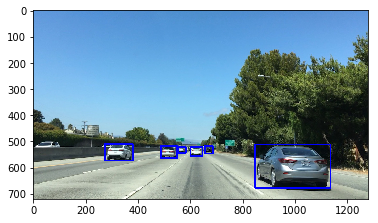

In [281]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread('C:\\data\\detection\\templates\\bbox-example-image.jpg')
#image = mpimg.imread('temp-matching-example-2.jpg')
#templist = ['cutout1.jpg', 'cutout2.jpg', 'cutout3.jpg',
#            'cutout4.jpg', 'cutout5.jpg', 'cutout6.jpg']
templist = glob.glob('C:\\data\\detection\\templates\\cutout*.jpg')

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy
    
# Define a function that takes an image and a list of templates as inputs
# then searches the image and returns the a list of bounding boxes 
# for matched templates
def find_matches(img, template_list):
    imcopy = np.copy(img)
    bbox_list = []
    for temp in template_list:
        temp_img = mpimg.imread(temp)
        res = cv2.matchTemplate(imcopy, temp_img, cv2.TM_CCORR_NORMED)
        # Use cv2.minMaxLoc() to extract the location of the best match
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
        # Determine bounding box corners for the match
        w, h = (temp_img.shape[1], temp_img.shape[0])
        top_left = max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)
        # Append bbox position to list
        bbox_list.append((top_left, bottom_right))
    # Return the list of bounding boxes
    return bbox_list

bboxes = find_matches(image, templist)
result = draw_boxes(image, bboxes)
plt.imshow(result)

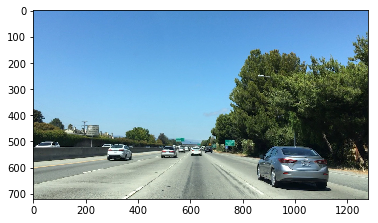

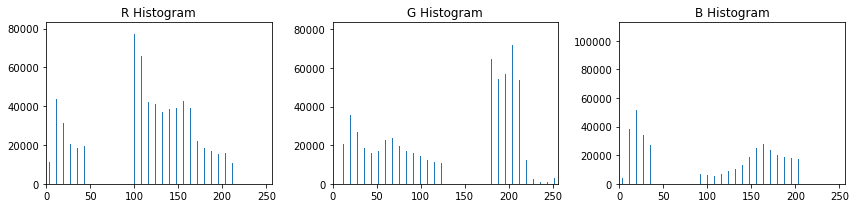

In [310]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

image = mpimg.imread('C:\\data\\detection\\templates\\bbox-example-image.jpg')

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(image[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(image[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(image[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features
    
rh, gh, bh, bincen, feature_vec = color_hist(image, nbins=32, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    plt.imshow(image)
    fig = plt.figure(figsize=(12,3))
    
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
    
else:
    print('Your function is returning None for at least one variable...')

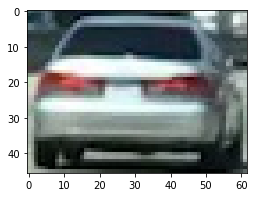

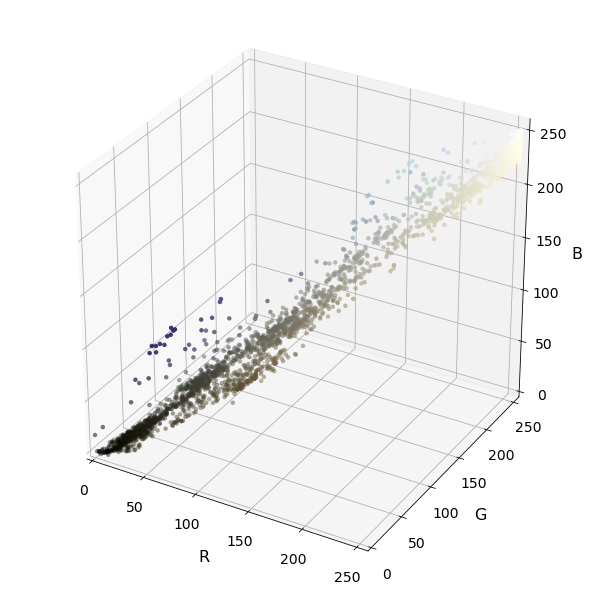

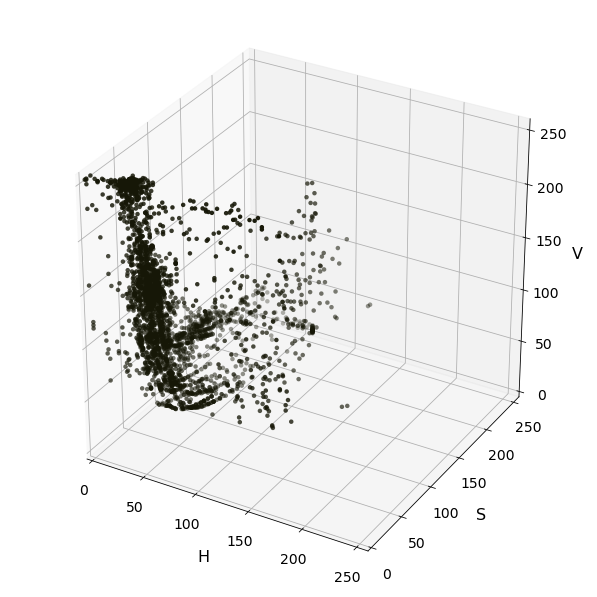

In [313]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot3d(pixels, colors_rgb, axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation


# Read a color image
img = mpimg.imread('C:\\data\\detection\\templates\\cutout2.jpg')

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 256) / 256  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
#img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

plt.figure(figsize=(12,3))
plt.imshow(img)

# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.show()

plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()

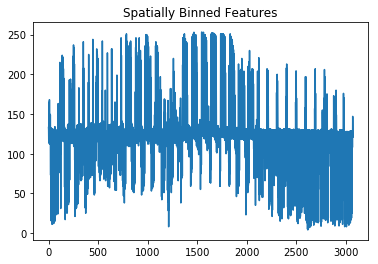

In [288]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read in an image
# You can also read cutout2, 3, 4 etc. to see other examples
image = mpimg.imread('C:\\data\\detection\\templates\\cutout1.jpg')

# compute color histogram features  
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    if color_space == 'RGB':
        feature_image = np.copy(img)   
    elif color_space == 'HSV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif color_space == 'LUV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    elif color_space == 'HLS':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif color_space == 'YUV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    elif color_space == 'YCrCb':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
       
    # create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    return features
    
feature_vec = bin_spatial(image, color_space='YUV', size=(32, 32))

# Plot features
plt.plot(feature_vec)
plt.title('Spatially Binned Features')



Your function returned a count of 1196  cars and 1125  non-cars
of size:  (64, 64, 3)  and data type: uint8


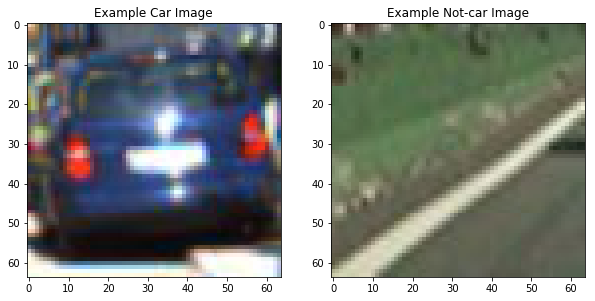

In [185]:


images = glob.glob('C:\\data\\detection\\class\\vehicles_smallset\*\*.jpeg')
images = images + glob.glob('C:\\data\\detection\\class\\non-vehicles_smallset\*\*.jpeg')

cars = []
notcars = []

for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
        
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    # Define a key "image_shape" and store the test image shape 3-tuple
    image = mpimg.imread(car_list[0])
    data_dict["image_shape"] = image.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = image.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Plot the examples
plt.figure(figsize=(10, 20))
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')


C:\ProgramData\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


features length =  509436


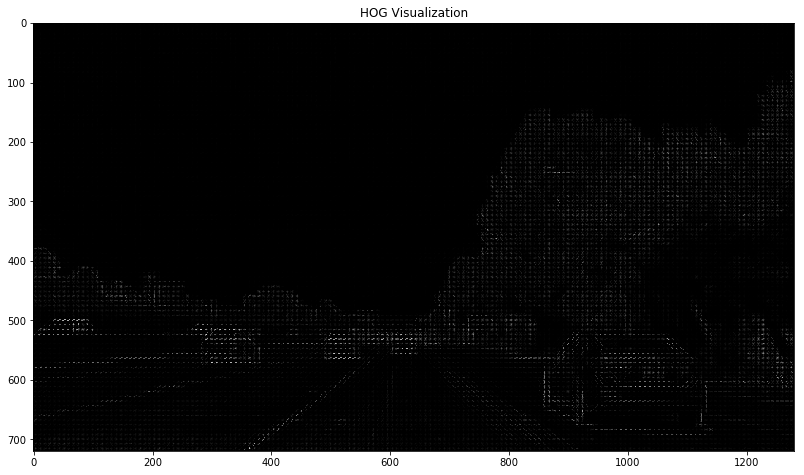

In [322]:

image = mpimg.imread('C:\\data\\detection\\templates\\bbox-example-image.jpg')

gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)


print('features length = ',len(features))
# Plot the examples
fig = plt.figure(figsize=(30,9))
#plt.subplot(121)
#plt.imshow(image, cmap='gray')
#plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

features length =  1764


C:\ProgramData\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


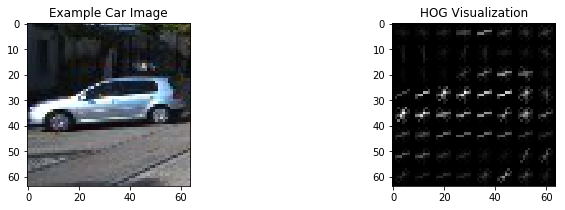

In [303]:


# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
        return features



# Read in our vehicles and non-vehicles
images = glob.glob('C:\\data\\detection\\class\\vehicles_smallset\*\*.jpeg')
images = images + glob.glob('C:\\data\\detection\\class\\non-vehicles_smallset\*\*.jpeg')
cars = []
notcars = []

for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)

# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])


gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)


print('features length = ',len(features))
# Plot the examples
fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')


In [199]:
images = glob.glob('C:\\data\\detection\\class\\vehicles_smallset\*\*.jpeg')
images = images + glob.glob('C:\\data\\detection\\class\\non-vehicles_smallset\*\*.jpeg')
cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
        
car_features = extract_features(cars, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256))
notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256))


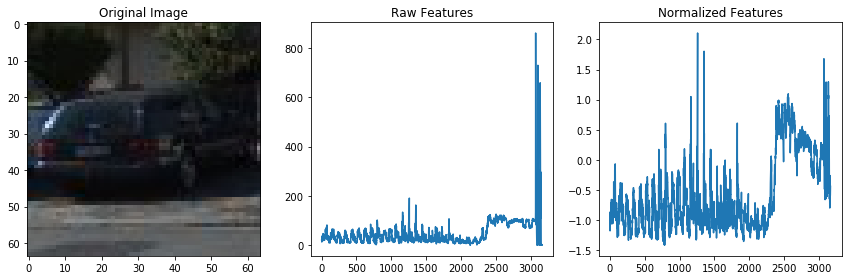

In [308]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
import glob

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
        # Read in each one by one
    for img in imgs:
        image = mpimg.imread(img)
    # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)  
    # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
    # Apply color_hist() to get color histogram features
        histogram_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
    # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, histogram_features)))
    # Return list of feature vectors
    return features

images = glob.glob('C:\\data\\detection\\class\\vehicles_smallset\*\*.jpeg')
images = images + glob.glob('C:\\data\\detection\\class\\non-vehicles_smallset\*\*.jpeg')
cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
        
car_features = extract_features(cars, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256))
notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256))


if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

In [182]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
# from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features


# TODO play with these values to see how your classifier
# performs under different binning scenarios
spatial = 32
histbin = 64

car_features = extract_features(cars, cspace='RGB', spatial_size=(spatial, spatial), hist_bins=histbin, hist_range=(0, 256))
notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(spatial, spatial), hist_bins=histbin, hist_range=(0, 256))

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',spatial, 'and', histbin, 'histogram bins')
print('Feature vector length:', len(X_train[0]))


# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')


# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts:     ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using spatial binning of: 32 and 64 histogram bins
Feature vector length: 3264
2.7 Seconds to train SVC...
Test Accuracy of SVC =  0.9892
My SVC predicts:      [ 0.  1.  1.  0.  1.  0.  1.  1.  0.  0.]
For these 10 labels:  [ 0.  1.  1.  0.  1.  0.  1.  1.  0.  0.]
0.001 Seconds to predict 10 labels with SVC


In [188]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features


# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
sample_size = 1000
cars_sample = cars[0:sample_size]
notcars_sample = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(cars_sample, cspace=colorspace, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
notcar_features = extract_features(notcars_sample, cspace=colorspace, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split( scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

C:\ProgramData\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


13.61 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292
0.67 Seconds to train SVC...
Test Accuracy of SVC =  0.965
My SVC predicts:  [ 1.  0.  1.  0.  1.  1.  1.  1.  0.  1.]
For these 10 labels:  [ 1.  0.  1.  0.  1.  1.  1.  1.  0.  1.]
0.001 Seconds to predict 10 labels with SVC


Total windows:  38


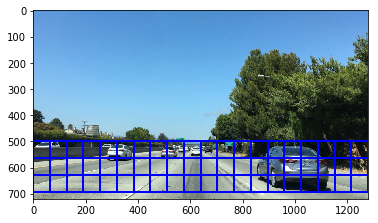

In [330]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread('C:\\data\\detection\\templates\\bbox-example-image.jpg')

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
   # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, so looping makes sense
    for ys in range(ny_windows):
        starty = ys*ny_pix_per_step + y_start_stop[0]
        endy = starty + xy_window[1]
        for xs in range(nx_windows):
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[500, 720], xy_window=(128, 128), xy_overlap=(0.5, 0.5))
print('Total windows: ',len(windows)                       )
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


(2321, 6108)
(2321, 6108)
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
0.67 Seconds to train SVC...
Test Accuracy of SVC =  0.9892


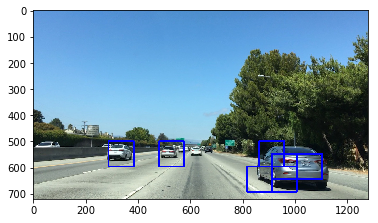

In [345]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split


# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    
    
# Read in cars and notcars
images = glob.glob('C:\\data\\detection\\class\\vehicles_smallset\*\*.jpeg')
images = images + glob.glob('C:\\data\\detection\\class\\non-vehicles_smallset\*\*.jpeg')
cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)

color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)   
print(X.shape)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
print(scaled_X.shape)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

image = mpimg.imread('C:\\data\\detection\\templates\\bbox-example-image.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[500,700], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

output = open("svc_pickle.p", 'wb')
dist_pickle = {}
dist_pickle["svc"] = svc
dist_pickle["scaler"] = X_scaler
dist_pickle["orient"] = orient
dist_pickle["pix_per_cell"] = pix_per_cell
dist_pickle["cell_per_block"] = cell_per_block
dist_pickle["spatial_size"] = spatial_size
dist_pickle["hist_bins"] = hist_bins
pickle.dump(dist_pickle, output)
output.close()

C:\ProgramData\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


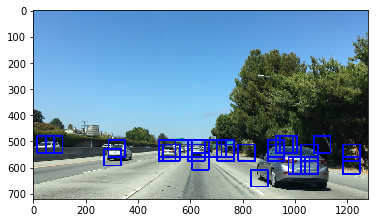

In [374]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2

dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]


def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    elif conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    elif conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    else:
        return img
    
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                box_list.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])
    return draw_img

box_list = []    
ystart = 480
ystop = 700
scale = 1

image = mpimg.imread('C:\\data\\detection\\templates\\bbox-example-image.jpg')
out_img = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
plt.imshow(out_img)

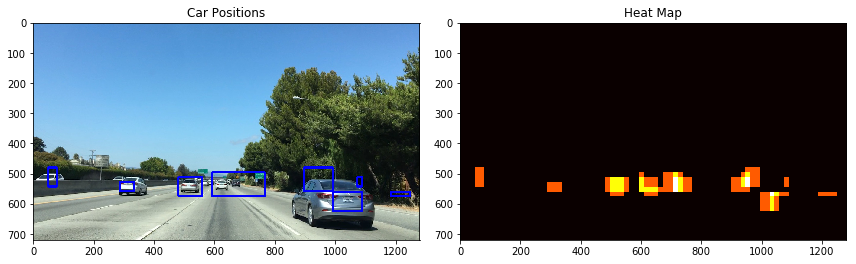

In [375]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label

# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
#box_list = pickle.load( open( "bbox_pickle.p", "rb" ))

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

heat = np.zeros_like(out_img[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure(figsize=(12,10))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
